# EVI and GDP Analysis

## Library

In [1]:
from pathlib import Path
import ast

import plotnine as p9
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import shap
import numpy as np

import warnings

warnings.filterwarnings("ignore")

PROJECT_ROOT = Path().cwd().parent.parent
DATA_PATH = PROJECT_ROOT / "data"
EVI_PATH = DATA_PATH / "EVI and Crop Land" / "EVI 2010-2025"
CROPLAND_PATH = DATA_PATH / "EVI and Crop Land" / "Crop Land"
BOUNDARIES_PATH = DATA_PATH / "Shapefiles"

## Functions

In [2]:
def preprocess_evi(evi_file: str | Path) -> pd.DataFrame:
    """Preprocess EVI CSV file."""
    evi_df = pd.read_csv(evi_file)

    metadata_cols = [
        col for col in evi_df.columns if "EVI" not in col and "system:index" not in col
    ]
    evi_df = (
        evi_df.rename(columns=lambda col: col[-14:] if col.endswith("_EVI") else col)
        .drop(columns=["system:index"])
        .melt(
            id_vars=metadata_cols,
            var_name="band_date",
            value_name="EVI",
        )
        .assign(
            date=lambda df: pd.to_datetime(
                df["band_date"].str.extract(r"(\d{4}_\d{2}_\d{2})")[0],
                format="%Y_%m_%d",
            ),
        )
    )
    return evi_df


def clean_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names."""
    df = df.rename(columns=lambda col: col.strip().lower().replace(" ", "_"))
    return df


def format_currency_labels(label: list[float]) -> list[str]:
    """Format currency labels by shortening large numbers with K, M, B suffixes."""
    labels = []
    for v in label:
        if v >= 1_000_000_000:
            labels.append("{:.1f}B".format(v / 1_000_000_000))
        elif v >= 1_000_000:
            labels.append("{:.1f}M".format(v / 1_000_000))
        elif v >= 1_000:
            labels.append("{:.1f}K".format(v / 1_000))
        else:
            labels.append(str(v))
    return labels


def filter_growing_season(
    df: pd.DataFrame, start_month: int = 7, end_month: int = 2
) -> pd.DataFrame:
    # Check if season spans two calendar years
    if end_month < start_month:
        months = list(range(start_month, 13)) + list(range(1, end_month + 1))
        season_data = df[df["date"].dt.month.isin(months)].copy()

        # Assign next year months to the previous year
        season_data["year"] = pd.to_datetime(
            season_data["date"].apply(
                lambda x: f"{x.year - 1}-01-01"
                if x.month <= end_month
                else f"{x.year}-01-01"
            )
        )
    else:
        months = list(range(start_month, end_month + 1))
        season_data = df[df["date"].dt.month.isin(months)].copy()

        season_data["year"] = pd.to_datetime(
            season_data["date"].dt.year.astype(str) + "-01-01"
        )

    return season_data

## Data

This analysis utilizes the following datasets:

* Overall GDP Data: Sourced from the World Bank World Development Indicators (WDI) database
* Sectoral GDP Data: Provided by the Myanmar team
* Enhanced Vegetation Index (EVI) Data: Derived from MODIS satellite imagery

In [3]:
gdp_overall = (
    (
        pd.read_csv(DATA_PATH / "GDP" / "GDP All Countries.csv", skiprows=4)
        .pipe(clean_names)
        .loc[lambda df: df["country_name"] == "Myanmar"]
    )
    .melt(
        id_vars=["country_name", "country_code", "indicator_name", "indicator_code"],
        var_name="year",
        value_name="gdp_overall",
    )
    .dropna(subset=["gdp_overall"])
    .assign(
        date=lambda df: pd.to_datetime(df["year"], format="%Y"),
        gdp_overall=lambda df: df["gdp_overall"] / 1_000_000,
    )
    .set_index("date")
)

exports = (
    pd.read_excel(
        DATA_PATH / "GDP" / "01_Myanmar_ag_exports_monthly.xlsx",
        skiprows=6,
        usecols="B:G",
    )
    .pipe(clean_names)
    .assign(date=lambda df: pd.to_datetime(df["period"], format="%Y%m"))
)

In [4]:
gdp_quarterly_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx",
    sheet_name=1,
    skiprows=1,
    skipfooter=1,
)
gdp_adm1_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx", sheet_name=0, skiprows=1
).rename(columns={"Unnamed: 0": "ADM1_NAME"})

evi_adm0_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 0"
                / "MIMU"
                / f"myanmar_adm0_evi_stats_{year}.csv"
            )
            for year in range(2010, 2026)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["date"])
    .reset_index(drop=True)
    .set_index("date")
)
evi_adm1_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 1"
                / "MIMU"
                / f"myanmar_adm1_evi_stats_{year}_batch{batch}.csv"
            )
            for year in range(2010, 2026)
            for batch in range(1, 4)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["ST", "date"])
    .reset_index(drop=True)
    .rename(columns={"ST": "adm1_name"})
    .set_index("date")
)

evi_adm0 = (
    evi_adm0_raw.groupby(pd.Grouper(freq="QS")).agg({"EVI": "median"}).pipe(clean_names)
)

evi_adm1 = (
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"EVI": "median"})
    .pipe(clean_names)
)

In [5]:
ntl_adm0_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm0_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)
ntl_adm1_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm1_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)

ntl_adm0 = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="QS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
    .assign(
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(-1),
        ntl_sum_lag_2=lambda df: df["ntl_sum"].shift(-2),
    )
)

ntl_adm1 = (
    ntl_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

In [6]:
gdp_adm1_name_map = {
    "Ayeyarwaddy Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magwe Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw Council": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Tanintharyi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def preprocess_bago_and_shan(df: pd.DataFrame) -> pd.DataFrame:
    """Split the values of Bago into two equal parts and Shan into three equal parts."""
    df_bago = df.query("adm1_name == 'Bago'").copy()
    df_bago_new = pd.DataFrame(
        {
            "adm1_name": ["Bago (East)", "Bago (West)"],
            "agriculture": [df_bago["agriculture"].values[0] / 2] * 2,
            "industry": [df_bago["industry"].values[0] / 2] * 2,
            "services": [df_bago["services"].values[0] / 2] * 2,
        }
    )

    df_shan = df.query("adm1_name == 'Shan'").copy()
    df_shan_new = pd.DataFrame(
        {
            "adm1_name": ["Shan (South)", "Shan (East)", "Shan (North)"],
            "agriculture": [df_shan["agriculture"].values[0] / 3] * 3,
            "industry": [df_shan["industry"].values[0] / 3] * 3,
            "services": [df_shan["services"].values[0] / 3] * 3,
        }
    )

    df_rest = df.query("adm1_name not in ['Bago', 'Shan']").copy()

    return pd.concat([df_rest, df_bago_new, df_shan_new], ignore_index=True)


gdp_adm1 = (
    gdp_adm1_raw.pipe(clean_names)
    .assign(adm1_name=lambda df: df["adm1_name"].map(gdp_adm1_name_map))
    .pipe(preprocess_bago_and_shan)
    .assign(agriculture_pct=lambda df: df["agriculture"] / df["agriculture"].sum())
)

gdp_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        quarter_clean=lambda df: df["quarter"].str.strip(),
        year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
        year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
        # Map fiscal quarters to calendar quarters and years
        calendar_quarter=lambda df: df["quarter_clean"].map(
            {"Q1": "Q2", "Q2": "Q3", "Q3": "Q4", "Q4": "Q1"}
        ),
        year_selected=lambda df: df.apply(
            lambda row: row["year_last"]
            if row["quarter_clean"] == "Q4"
            else row["year_first"],
            axis=1,
        ),
        # year_selected=lambda df: df.apply(
        #     lambda row: row["year_last"]
        #     if row["quarter_clean"] in ["Q1", "Q2"]
        #     else row["year_first"],
        #     axis=1,
        # ),
        date=lambda df: pd.to_datetime(df["year_selected"] + df["calendar_quarter"]),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .query('sub_group == "Agriculture" and economic_activity == "Agriculture"')
    .set_index("date")
    .sort_index()
    .groupby(["sub_group", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
    .reset_index()
    .sort_values(["sub_group", "date"])
    .groupby("sub_group")
    .apply(
        lambda df: df.assign(
            gdp_lag_1=df["gdp"].shift(1),
            gdp_lag_2=df["gdp"].shift(2),
        )
    )
    .reset_index(drop=True)
    .set_index(["sub_group", "date"])
)

gdp_agri_quarterly = (
    gdp_quarterly.reset_index()
    .query('sub_group == "Agriculture"')
    .rename(
        columns={
            "gdp": "gdp_agri",
            "gdp_lag_1": "gdp_agri_lag_1",
            "gdp_lag_2": "gdp_agri_lag_2",
        }
    )
    .drop(columns=["sub_group"])
    .set_index("date")
)

gdp_agri_quarterly_adm1 = pd.DataFrame(
    [
        (region, period)
        for region in gdp_adm1["adm1_name"].unique()
        for period in gdp_agri_quarterly.index.unique()
    ],
    columns=["adm1_name", "date"],
)

gdp_agri_quarterly_adm1 = (
    gdp_agri_quarterly_adm1.merge(
        gdp_adm1.filter(["adm1_name", "agriculture_pct"]), on="adm1_name", how="left"
    )
    .merge(gdp_agri_quarterly.reset_index(), on="date", how="left")
    .rename(
        columns={
            "gdp_agri": "gdp_agri_total",
            "gdp_agri_lag_1": "gdp_agri_lag_1_total",
            "gdp_agri_lag_2": "gdp_agri_lag_2_total",
        }
    )
    .assign(
        gdp_agri=lambda df: df["gdp_agri_total"] * df["agriculture_pct"],
        gdp_agri_lag_1=lambda df: df["gdp_agri_lag_1_total"] * df["agriculture_pct"],
        gdp_agri_lag_2=lambda df: df["gdp_agri_lag_2_total"] * df["agriculture_pct"],
    )
    .set_index(["adm1_name", "date"])
    .filter(["gdp_agri", "gdp_agri_lag_1", "gdp_agri_lag_2"])
)

In [7]:
def process_crop(
    year, sheet_name: str = "01 crop output", filepath: str | Path | None = None
) -> pd.DataFrame:
    """Process crop output data from Excel file."""

    year_skip_rows = {2021: 5, 2022: 25, 2023: 45}

    if year not in year_skip_rows:
        raise ValueError(
            f"Year {year} is not supported. Supported years: {list(year_skip_rows.keys())}"
        )

    if not filepath:
        filepath = DATA_PATH / "GDP" / "20251024_MEM_agric_data g.xlsx"

    crop_output = (
        pd.read_excel(
            filepath,
            sheet_name=sheet_name,
            usecols="A:BJ",
            skiprows=year_skip_rows[year],
            nrows=15,
        )
        .rename(columns={"Unnamed: 0": "year", "Unnamed: 2": "adm1_name"})
        .drop(columns=["Unnamed: 1"])
        .replace("-", np.nan)
    )
    return crop_output


crop_type_total_cols = [
    "CEREALS",
    "OILSEEDS",
    "PULSES",
    "SPICES AND CONDIMENTS",
    "TOBACCO AND BETEL",
    "BEVERAGES",
    "VEGETABLES AND FRUITS",
    "FIBRE",
    "MISC",
]

crop_adm1_name_map = {
    "Ayeyawady Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magway Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Taninthayi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


crop_output = (
    pd.concat(
        [process_crop(year, sheet_name="01 crop output") for year in range(2021, 2024)],
        ignore_index=True,
    )
    .melt(
        id_vars=["year", "adm1_name"],
        var_name="crop_type",
        value_name="output_in_tons",
    )
    .assign(
        adm1_name=lambda df: df["adm1_name"].str.strip().map(crop_adm1_name_map),
        year=lambda df: df["year"].str.split("-").str[0].astype(int),
    )
)

crop_harvested_area = (
    pd.concat(
        [
            process_crop(year, sheet_name="02 harvested area")
            for year in range(2021, 2024)
        ],
        ignore_index=True,
    )
    .melt(
        id_vars=["year", "adm1_name"],
        var_name="crop_type",
        value_name="harvested_area_in_acres",
    )
    .assign(
        adm1_name=lambda df: df["adm1_name"].str.strip().map(crop_adm1_name_map),
        year=lambda df: df["year"].str.split("-").str[0].astype(int),
    )
)

crops = crop_output.merge(
    crop_harvested_area, on=["year", "adm1_name", "crop_type"]
).assign(crop_yield=lambda df: df["output_in_tons"] / df["harvested_area_in_acres"])

## Harvest Area

Both actual harvested area and satellite-derived crop area has been scaled to the same unit (acres) for consistency in analysis. Both metrics are then ranked within each year to show the relative position of each crop and illustrate how closely the satellite-derived data aligns with actual harvested area.

In [8]:
def load_dict(input_str):
    input_str = input_str.replace("null", "'null'")
    input_str = input_str.replace("=", ":")
    result_dict = ast.literal_eval(input_str)
    return result_dict


crop_count_files = CROPLAND_PATH / "Admin level 1" / "MIMU"
dfs = []
for file in crop_count_files.glob("*.csv"):
    df = pd.read_csv(file).assign(
        year=file.stem.split("_")[-2],
        histogram=lambda df: df["histogram"].apply(load_dict),
    )
    dfs.append(df)

dfs = pd.concat(dfs, ignore_index=True)
dfs_area = (
    dfs.join(pd.json_normalize(dfs["histogram"]))
    .rename(columns={"null": "Other", 1: "crop_area", 0: "non_crop"})
    .fillna(0)
    .drop(columns=["histogram"])
    .loc[
        :,
        [
            "year",
            "ST",
            "ST_PCODE",
            "crop_area",
        ],
    ]
    .sort_values(["crop_area"], ascending=False)
)

satellite_crops_area = (
    dfs_area.assign(
        year=lambda df: df["year"].astype(int),
        # Each pixel is 10m x 10m = 100 m²; convert to acres (1 acre = 4046.86 m²)
        crop_area=lambda df: (df["crop_area"] * 100 / 4046.86),
        adm1_name=lambda df: df["ST"].apply(
            lambda x: "Bago" if "Bago" in x else ("Shan" if "Shan" in x else x)
        ),
    )
    .groupby(["adm1_name", "year"])
    .agg({"crop_area": "sum"})
    .reset_index()
)

In [9]:
crops_rank = (
    crops.groupby(["adm1_name", "year"], as_index=False)
    .agg({"harvested_area_in_acres": "sum"})
    .merge(
        satellite_crops_area,
        left_on=["adm1_name", "year"],
        right_on=["adm1_name", "year"],
        how="inner",
    )
    # group by year and calculate rank within each year
    .assign(
        actual_rank=lambda df: df.groupby("year")["harvested_area_in_acres"]
        .rank(method="min", ascending=False)
        .astype(int),
        satellite_rank=lambda df: df.groupby("year")["crop_area"]
        .rank(method="min", ascending=False)
        .astype(int),
    )
    .sort_values(["year", "crop_area"], ascending=[True, False])
)

crops_rank.head()

,adm1_name,year,harvested_area_in_acres,crop_area,actual_rank,satellite_rank
33,Sagaing,2021,15987316.0,4.130755e+06,1,1
0,Ayeyarwady,2021,15201800.0,3.081872e+06,2,2
3,Bago,2021,11755932.0,2.703700e+06,3,3
21,Mandalay,2021,8577972.0,2.535370e+06,4,4
18,Magway,2021,8399246.0,2.458484e+06,5,5


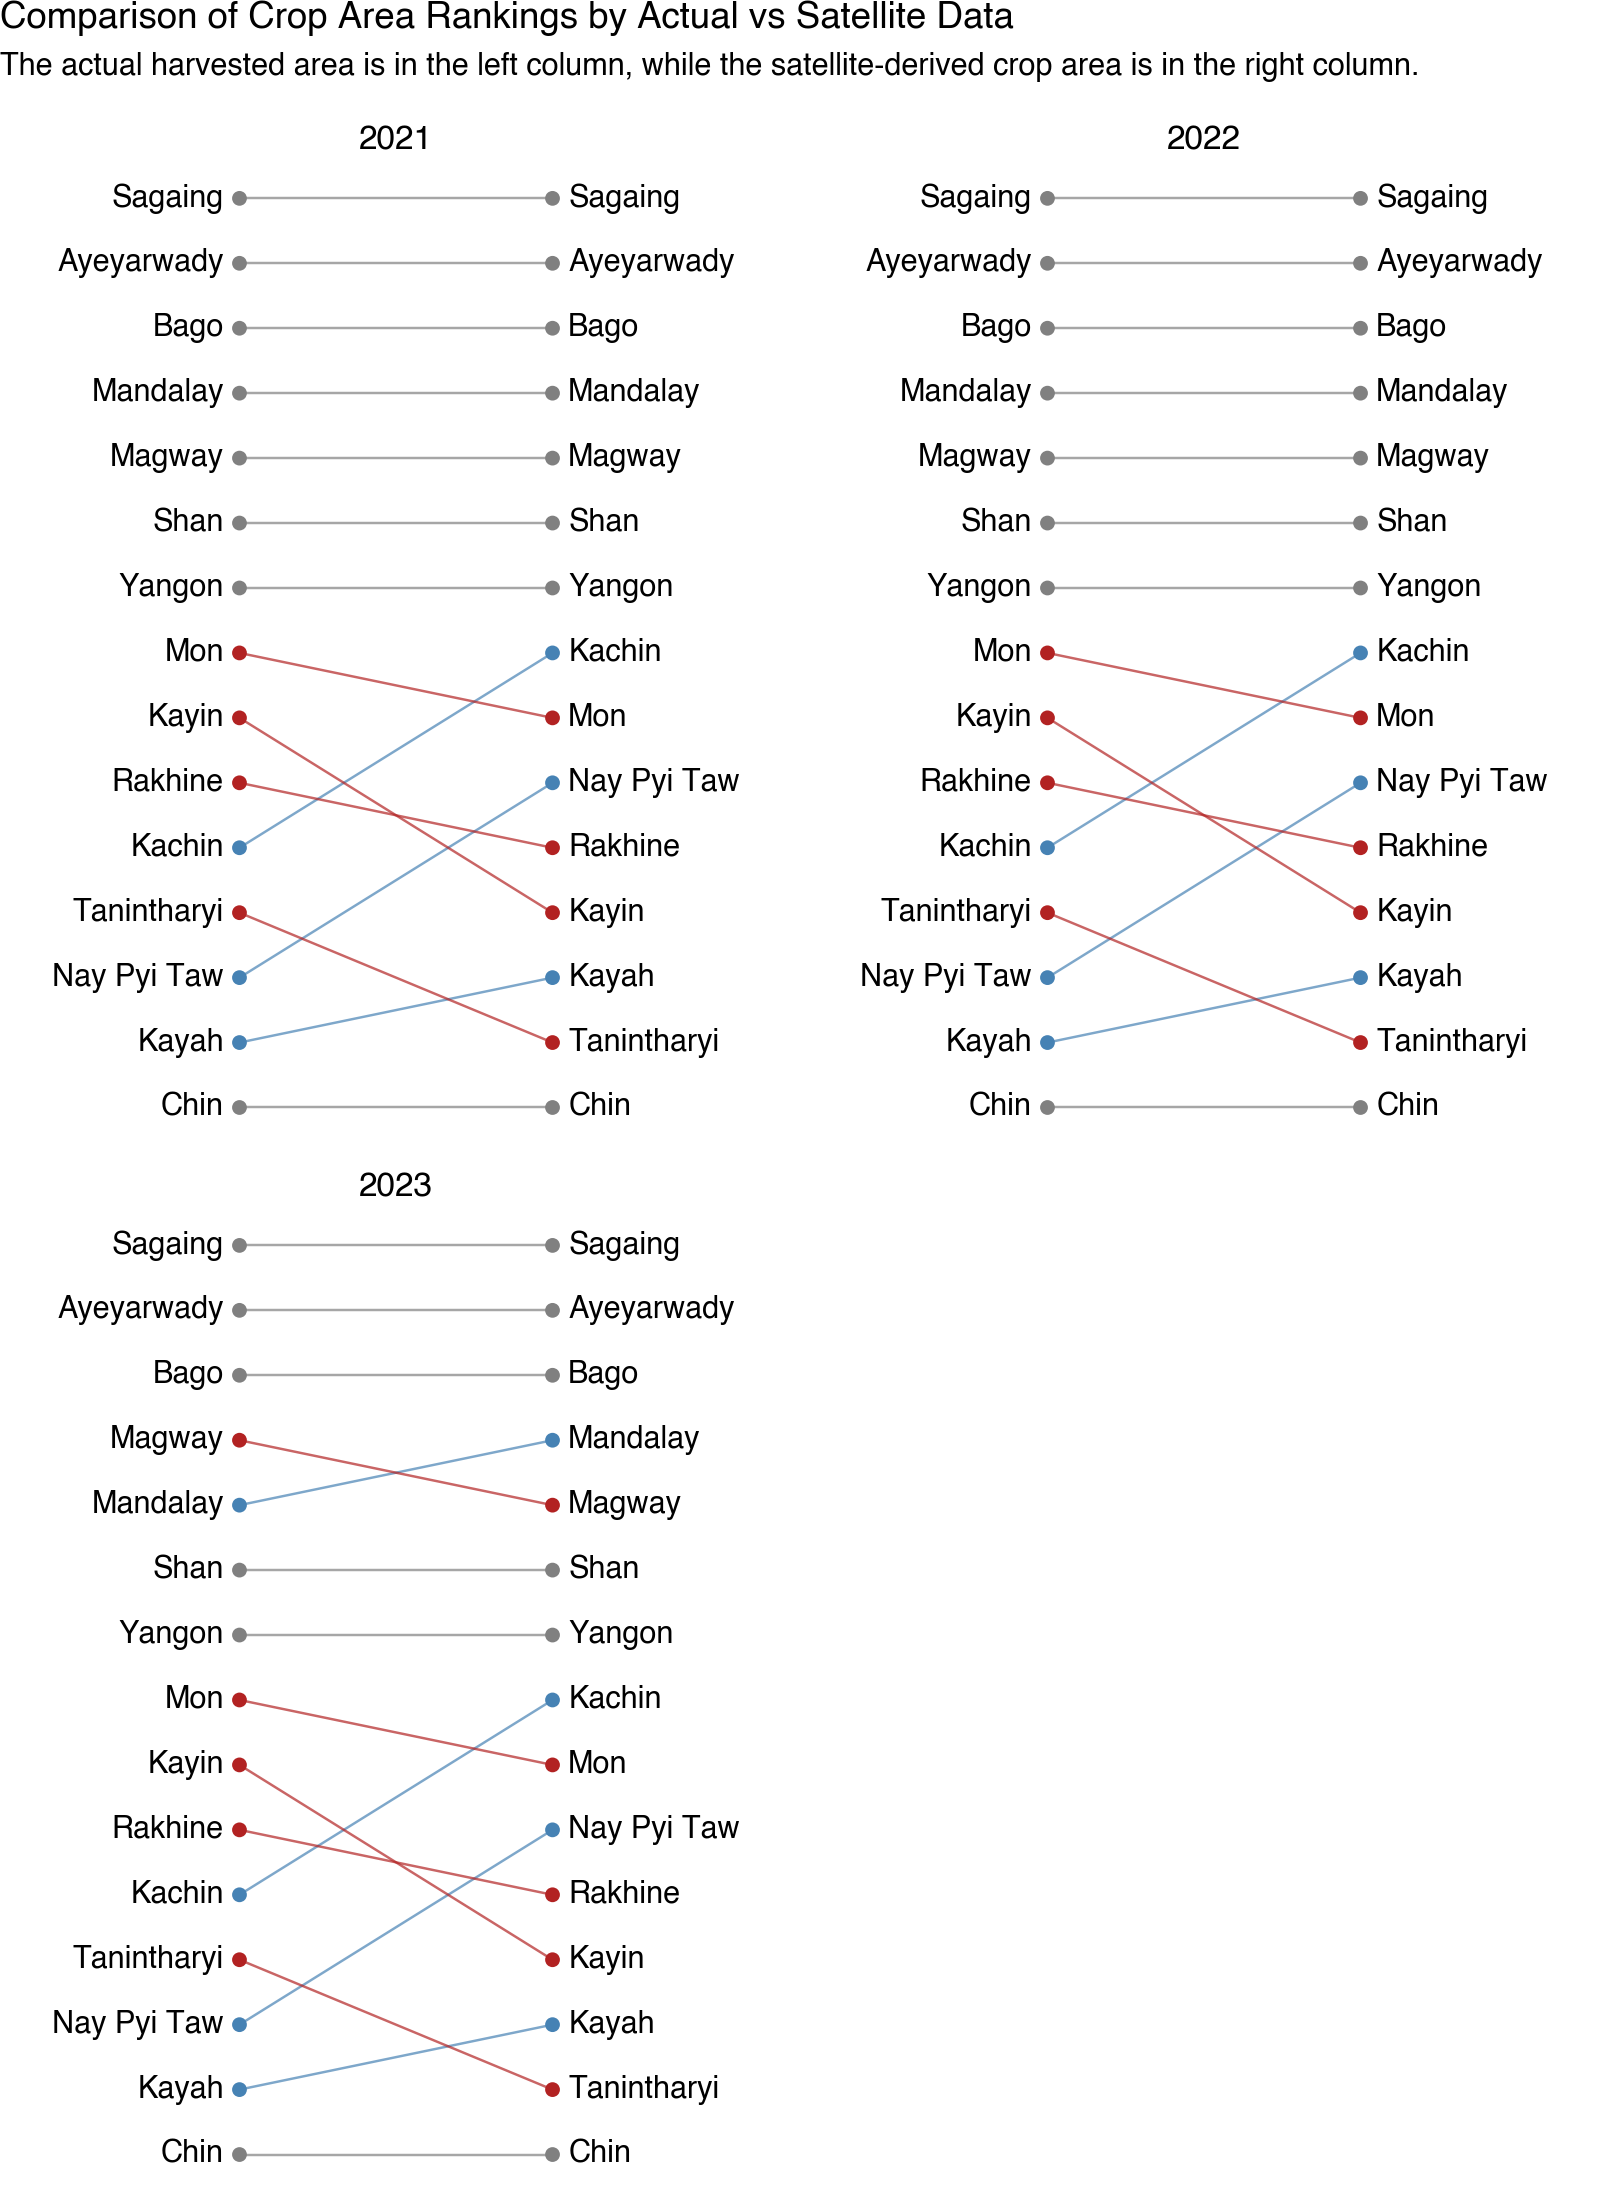

In [10]:
(
    crops_rank.assign(
        status=lambda df: np.where(
            df["satellite_rank"] < df["actual_rank"],
            "Actual Rank",
            np.where(
                df["satellite_rank"] > df["actual_rank"], "Satellite Rank", "Same Rank"
            ),
        )
    ).pipe((p9.ggplot, "data"))
    + p9.geom_text(
        p9.aes(1, "actual_rank", label="adm1_name"), nudge_x=-0.05, ha="right"
    )
    + p9.geom_text(
        p9.aes(2, "satellite_rank", label="adm1_name"), nudge_x=0.05, ha="left"
    )
    + p9.geom_point(
        p9.aes(x=1, y="actual_rank", color="status"),
        size=2,
    )
    + p9.geom_point(
        p9.aes(x=2, y="satellite_rank", color="status"),
        size=2,
    )
    + p9.geom_segment(
        p9.aes(
            x=1,
            y="actual_rank",
            xend=2,
            yend="satellite_rank",
            color="status",
        ),
        alpha=0.7,
    )
    + p9.scale_y_reverse()
    + p9.scale_color_manual(
        values={
            "Actual Rank": "steelblue",
            "Satellite Rank": "firebrick",
            "Same Rank": "gray",
        }
    )
    + p9.labs(
        x="",
        y="Rank (1 = Highest)",
        title="Comparison of Crop Area Rankings by Actual vs Satellite Data",
        subtitle="The actual harvested area is in the left column, while the satellite-derived crop area is in the right column.",
    )
    + p9.facet_wrap("year", ncol=2)
    + p9.lims(x=(0.35, 2.65))
    + p9.theme_void()
    + p9.theme(
        figure_size=(8, 11),
        plot_subtitle=p9.element_text(margin={"b": 20}),
        legend_position="none",
        strip_text=p9.element_text(size=12),
    )
)

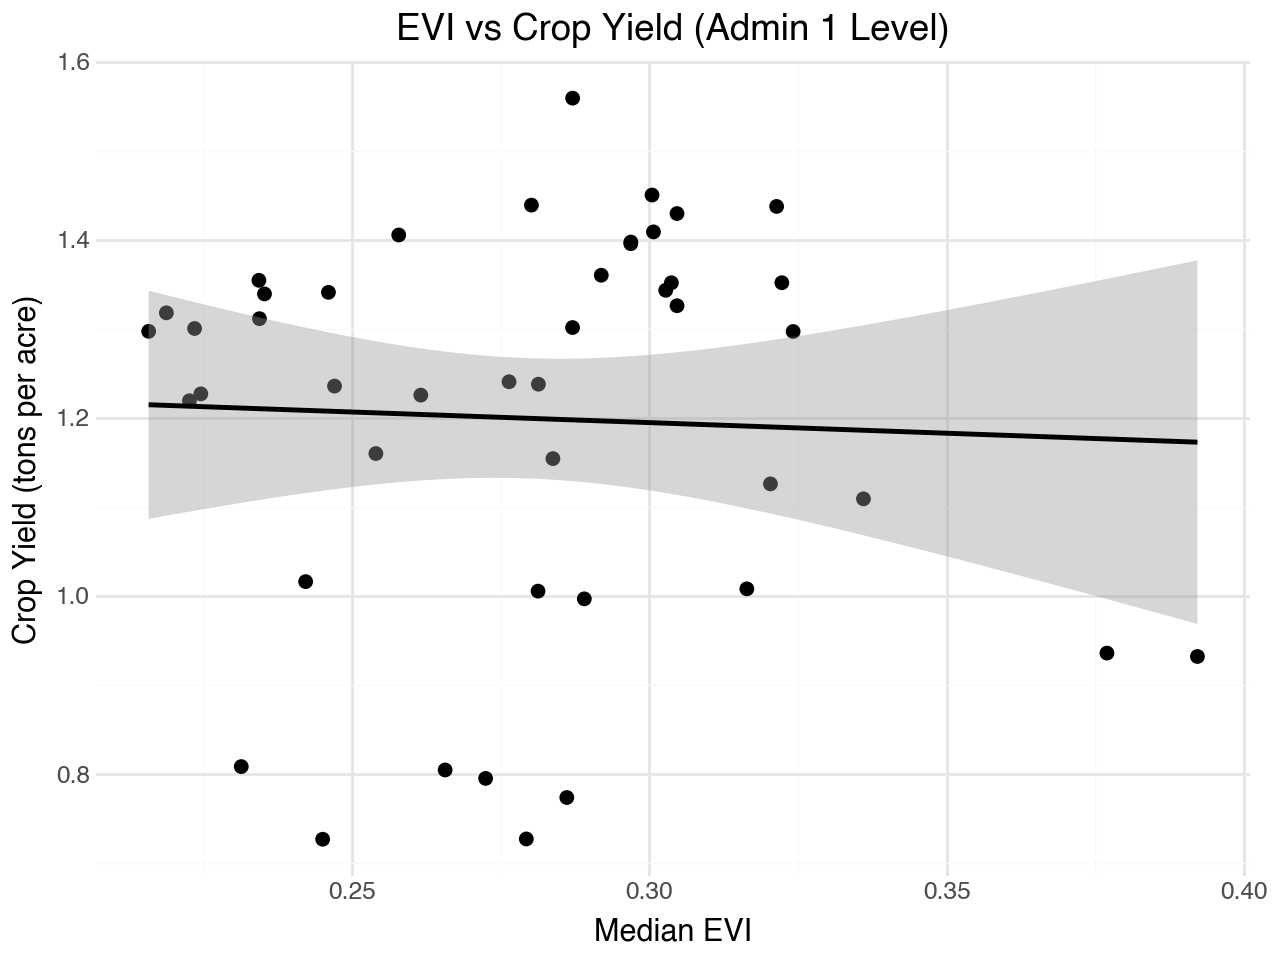

In [11]:
evi_adm1_annual = (
    evi_adm1_raw.assign(
        adm1_name=lambda df: df["adm1_name"].apply(
            lambda x: "Bago" if "Bago" in x else ("Shan" if "Shan" in x else x)
        ),
    )
    .groupby(["adm1_name", pd.Grouper(freq="YS")])
    .agg({"EVI": "median"})
)

crops_evi = (
    crops.groupby(["adm1_name", "year"], as_index=False)
    .agg({"harvested_area_in_acres": "sum", "output_in_tons": "sum"})
    .assign(
        date=lambda df: pd.to_datetime(df["year"], format="%Y"),
        crop_yield=lambda df: df["output_in_tons"] / df["harvested_area_in_acres"],
    )
    .set_index(["adm1_name", "date"])
    .join(evi_adm1_annual)
    .reset_index()
    .pipe(clean_names)
    .assign(
        evi_log=lambda df: np.log(df["evi"]),
        crop_yield_log=lambda df: np.log(df["crop_yield"]),
    )
)

(
    crops_evi.pipe((p9.ggplot, "data"))
    + p9.geom_point(p9.aes(x="evi", y="crop_yield"), size=2)
    + p9.geom_smooth(p9.aes(x="evi", y="crop_yield"), method="lm")
    + p9.labs(
        x="Median EVI",
        y="Crop Yield (tons per acre)",
        title="EVI vs Crop Yield (Admin 1 Level)",
    )
    + p9.theme_minimal()
)

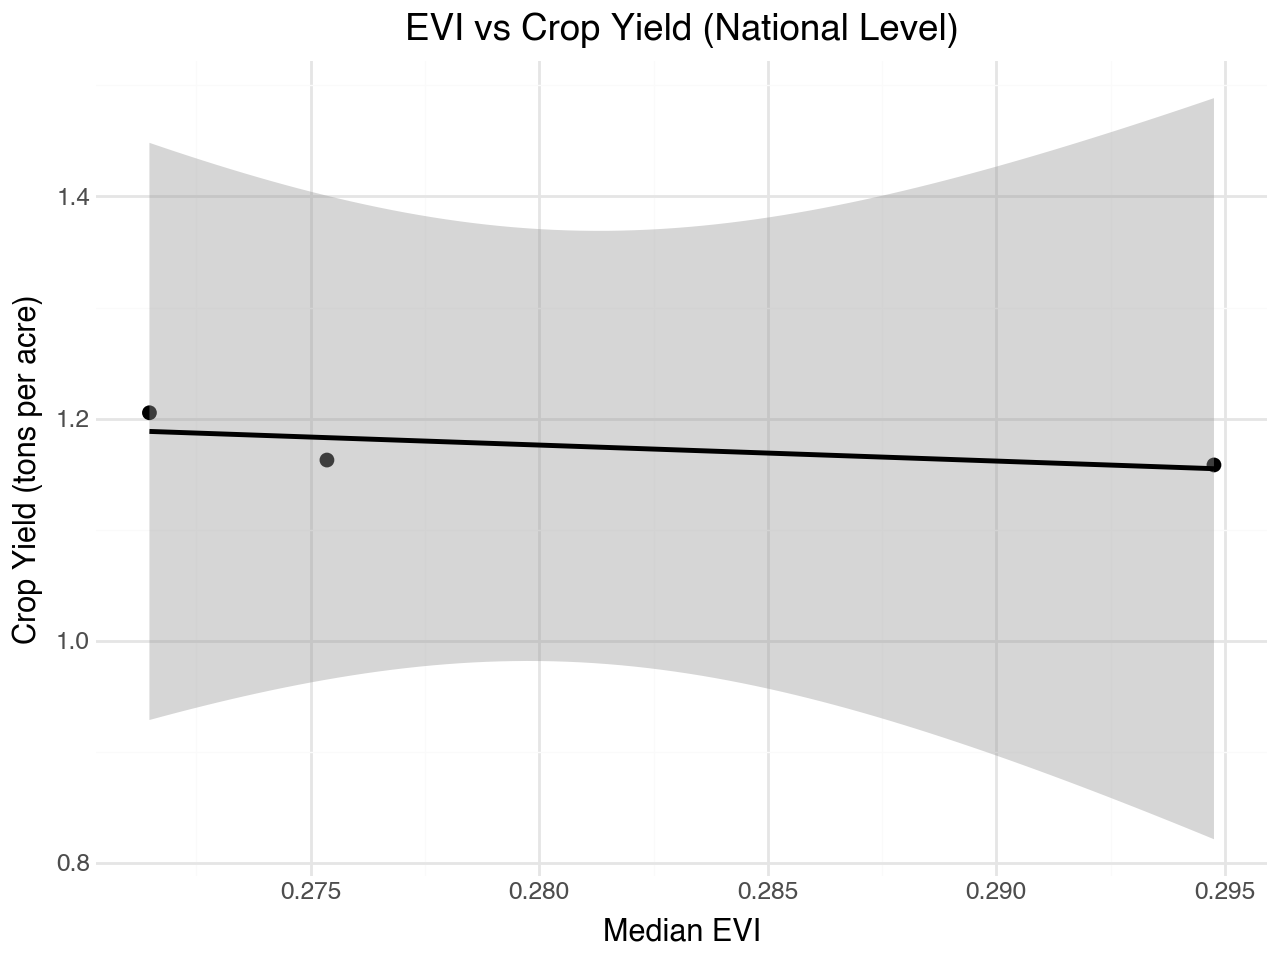

In [12]:
crops_evi = (
    crops.groupby(["year"], as_index=False)
    .agg({"harvested_area_in_acres": "sum", "output_in_tons": "sum"})
    .assign(
        date=lambda df: pd.to_datetime(df["year"], format="%Y"),
        crop_yield=lambda df: df["output_in_tons"] / df["harvested_area_in_acres"],
    )
    .set_index(["date"])
    .join(
        evi_adm1_raw.assign(
            adm1_name=lambda df: df["adm1_name"].apply(
                lambda x: "Bago" if "Bago" in x else ("Shan" if "Shan" in x else x)
            ),
        )
        .groupby(pd.Grouper(freq="YS"))
        .agg({"EVI": "median"})
    )
    .reset_index()
    .pipe(clean_names)
    .assign(
        evi_log=lambda df: np.log(df["evi"]),
        crop_yield_log=lambda df: np.log(df["crop_yield"]),
    )
)

(
    crops_evi.pipe((p9.ggplot, "data"))
    + p9.geom_point(p9.aes(x="evi", y="crop_yield"), size=2)
    + p9.geom_smooth(p9.aes(x="evi", y="crop_yield"), method="lm")
    + p9.labs(
        x="Median EVI",
        y="Crop Yield (tons per acre)",
        title="EVI vs Crop Yield (National Level)",
    )
    + p9.theme_minimal()
)

## Exports

In [13]:
exports

,period,total_vegetable_exports,beans_and_pulses,corn,rice,other,date
0,201101,210.54,130.23,4.65,66.30,9.36,2011-01-01
1,201102,221.77,148.41,4.85,60.53,7.98,2011-02-01
2,201103,274.88,183.48,7.07,71.24,13.09,2011-03-01
3,201104,154.51,128.44,8.36,10.39,7.32,2011-04-01
4,201105,362.27,272.78,19.93,59.90,9.66,2011-05-01
...,...,...,...,...,...,...,...
163,202408,727.45,324.73,131.15,169.95,101.62,2024-08-01
164,202409,660.40,256.43,6.25,325.54,72.18,2024-09-01
165,202410,559.26,205.71,5.76,219.64,128.15,2024-10-01
166,202411,619.66,199.39,2.83,324.94,92.50,2024-11-01


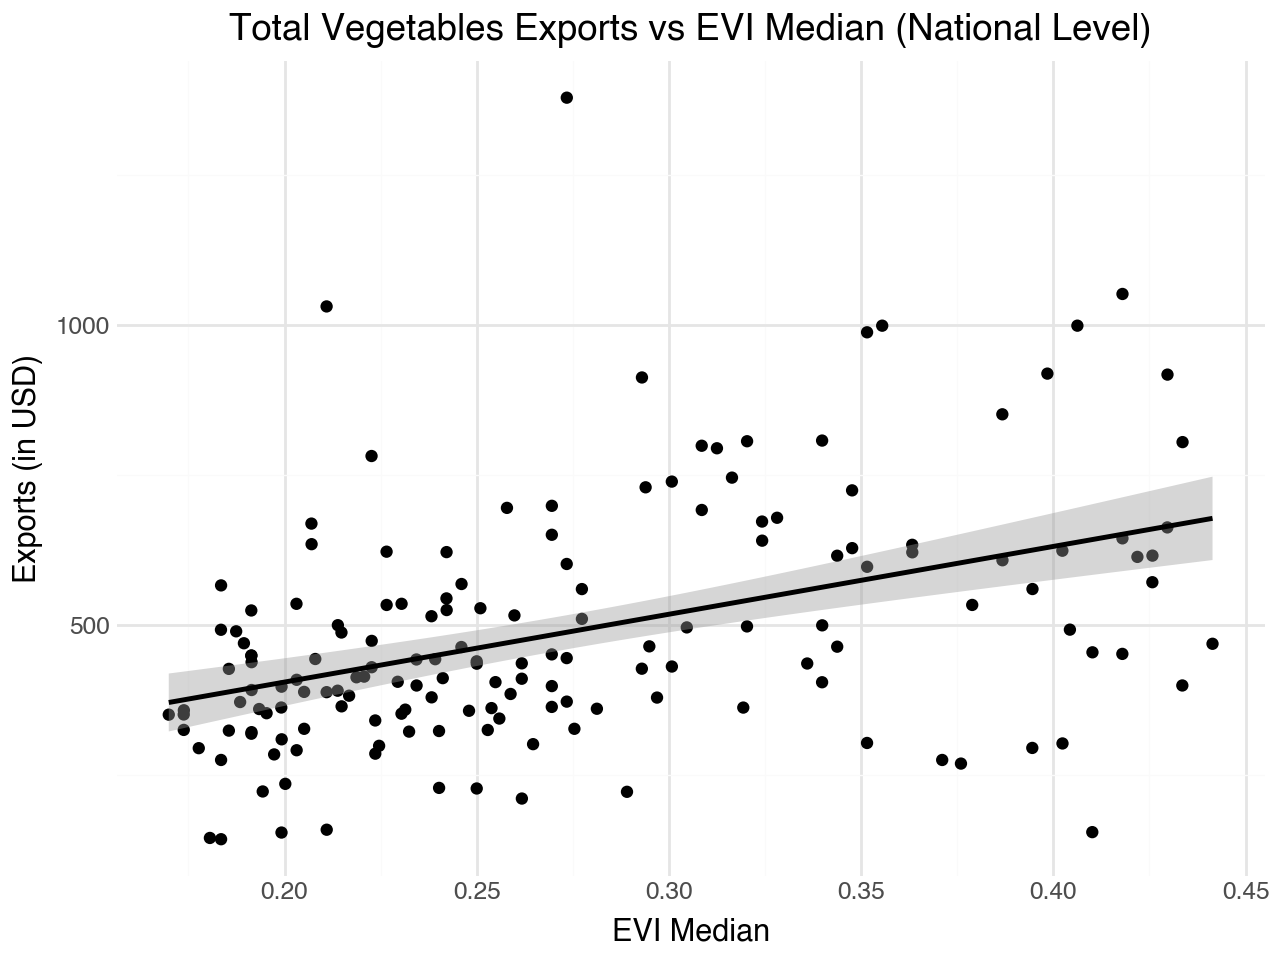

In [14]:
evi_adm0_monthly = (
    evi_adm0_raw.groupby(pd.Grouper(freq="MS")).agg({"EVI": "median"}).pipe(clean_names)
)

(
    exports.set_index("date")
    .join(evi_adm0_monthly, how="inner")
    .assign(
        total_vegetable_exports_lag_1=lambda df: df["total_vegetable_exports"].shift(6)
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="total_vegetable_exports_lag_1")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="Total Vegetables Exports vs EVI Median (National Level)",
        x="EVI Median",
        y="Exports (in USD)",
    )
    + p9.theme_minimal()
)

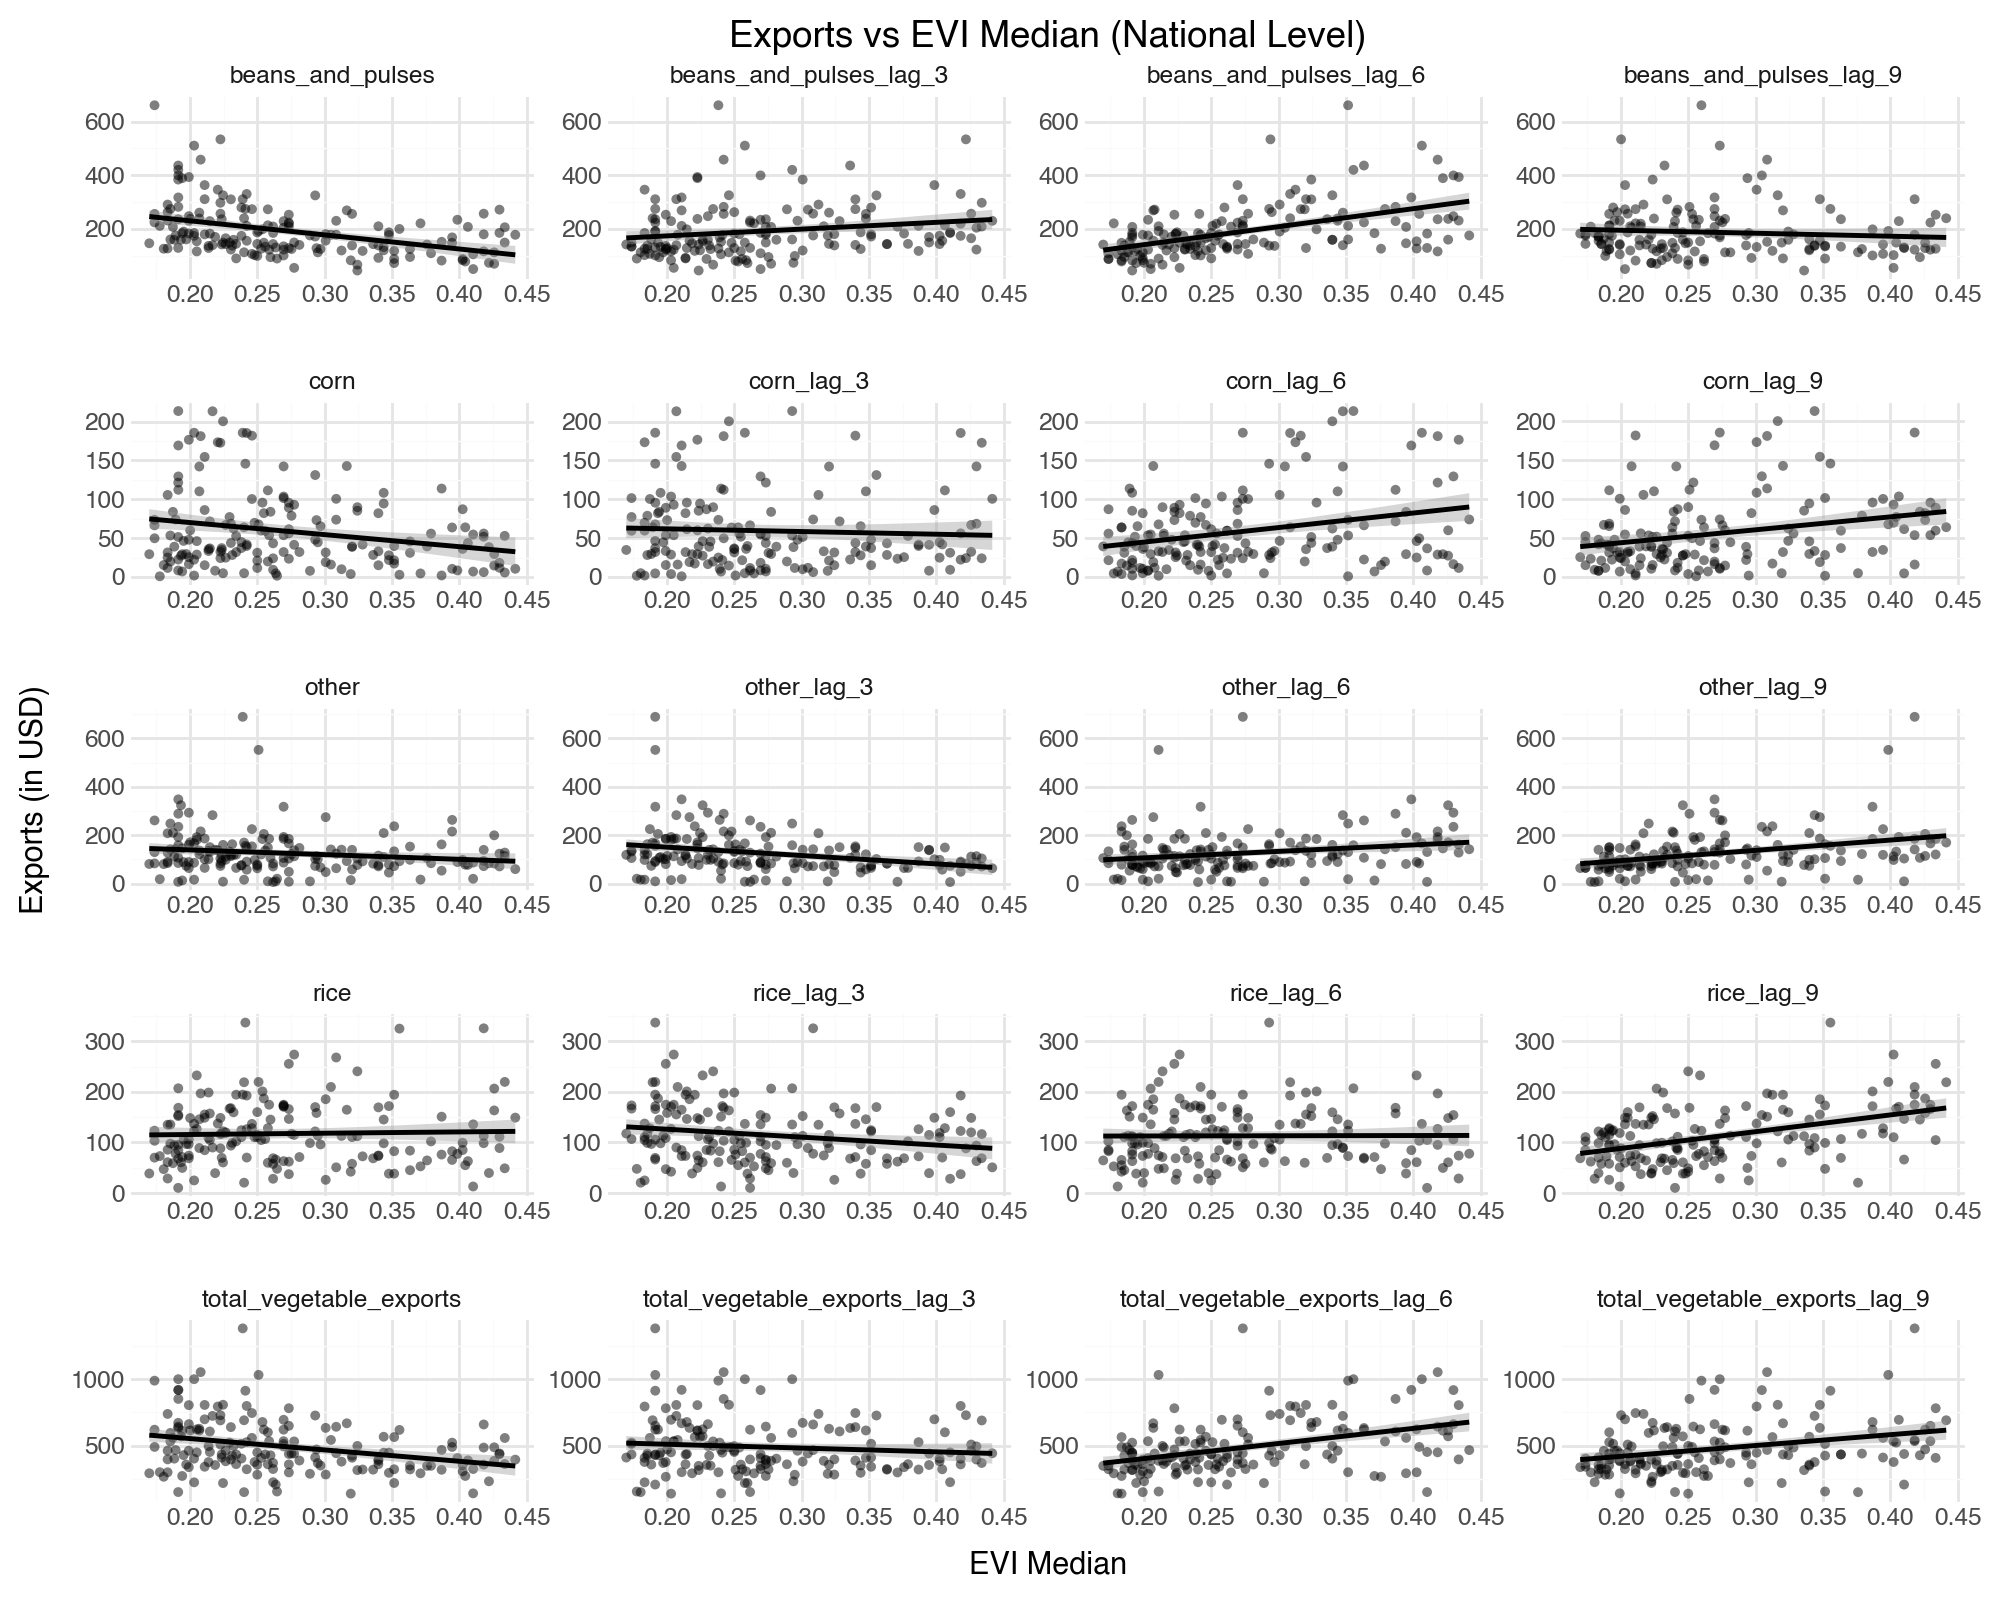

In [15]:
evi_adm0_monthly = (
    evi_adm0_raw.groupby(pd.Grouper(freq="MS")).agg({"EVI": "median"}).pipe(clean_names)
)

(
    exports.set_index("date")
    .join(evi_adm0_monthly, how="inner")
    .assign(
        total_vegetable_exports_lag_3=lambda df: df["total_vegetable_exports"].shift(3),
        total_vegetable_exports_lag_6=lambda df: df["total_vegetable_exports"].shift(6),
        total_vegetable_exports_lag_9=lambda df: df["total_vegetable_exports"].shift(9),
        beans_and_pulses_lag_3=lambda df: df["beans_and_pulses"].shift(3),
        beans_and_pulses_lag_6=lambda df: df["beans_and_pulses"].shift(6),
        beans_and_pulses_lag_9=lambda df: df["beans_and_pulses"].shift(9),
        corn_lag_3=lambda df: df["corn"].shift(3),
        corn_lag_6=lambda df: df["corn"].shift(6),
        corn_lag_9=lambda df: df["corn"].shift(9),
        rice_lag_3=lambda df: df["rice"].shift(3),
        rice_lag_6=lambda df: df["rice"].shift(6),
        rice_lag_9=lambda df: df["rice"].shift(9),
        other_lag_3=lambda df: df["other"].shift(3),
        other_lag_6=lambda df: df["other"].shift(6),
        other_lag_9=lambda df: df["other"].shift(9),
    )
    .reset_index()
    .melt(
        id_vars=["date", "period", "evi"],
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="value")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("variable", ncol=4, scales="free")
    + p9.labs(
        title="Exports vs EVI Median (National Level)",
        x="EVI Median",
        y="Exports (in USD)",
    )
    + p9.theme_minimal()
    + p9.theme(figure_size=(10, 8), panel_spacing_x=0.01, panel_spacing_y=0.04)
)

## Pre and Post 2021 coup d'état

The figure below shows the trend of EVI in Myanmar from 2012 to 2024, with a blue dotted line marking the 2021 coup d'état.

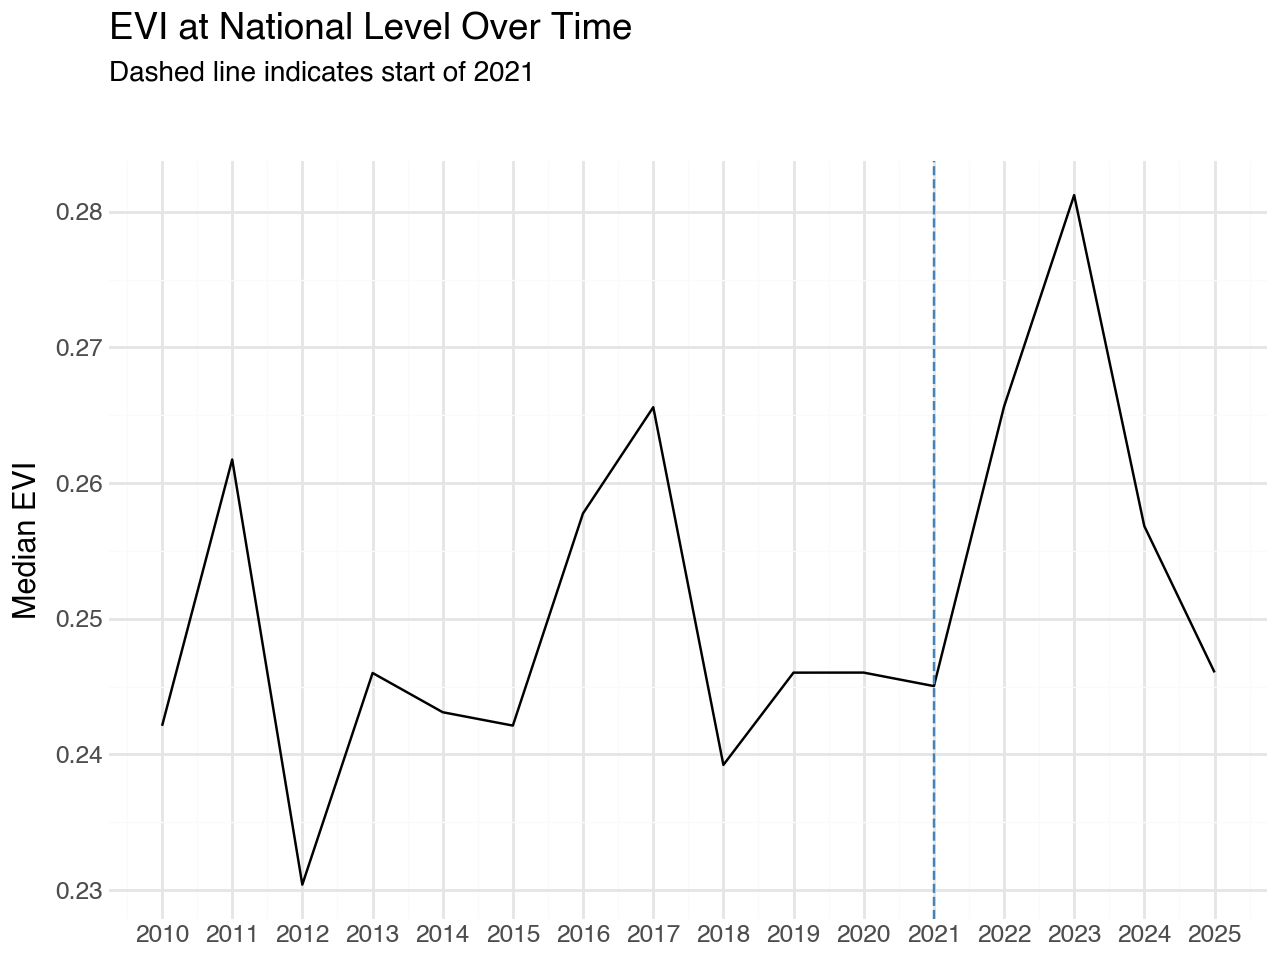

In [16]:
(
    evi_adm0_raw.groupby(pd.Grouper(freq="YS"))
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_line()
    + p9.geom_vline(
        p9.aes(xintercept=pd.to_datetime("2021-01-01")),
        linetype="dashed",
        color="steelblue",
    )
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="1 year")
    + p9.theme_minimal()
    + p9.labs(
        title="EVI at National Level Over Time",
        subtitle="Dashed line indicates start of 2021",
        x="",
        y="Median EVI",
    )
    + p9.theme(
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

The figure below illustrates the trend of EVI values across administrative level 1 regions in Myanmar from 2012 to 2024, with a blue dotted line marking the 2021 coup d'état.

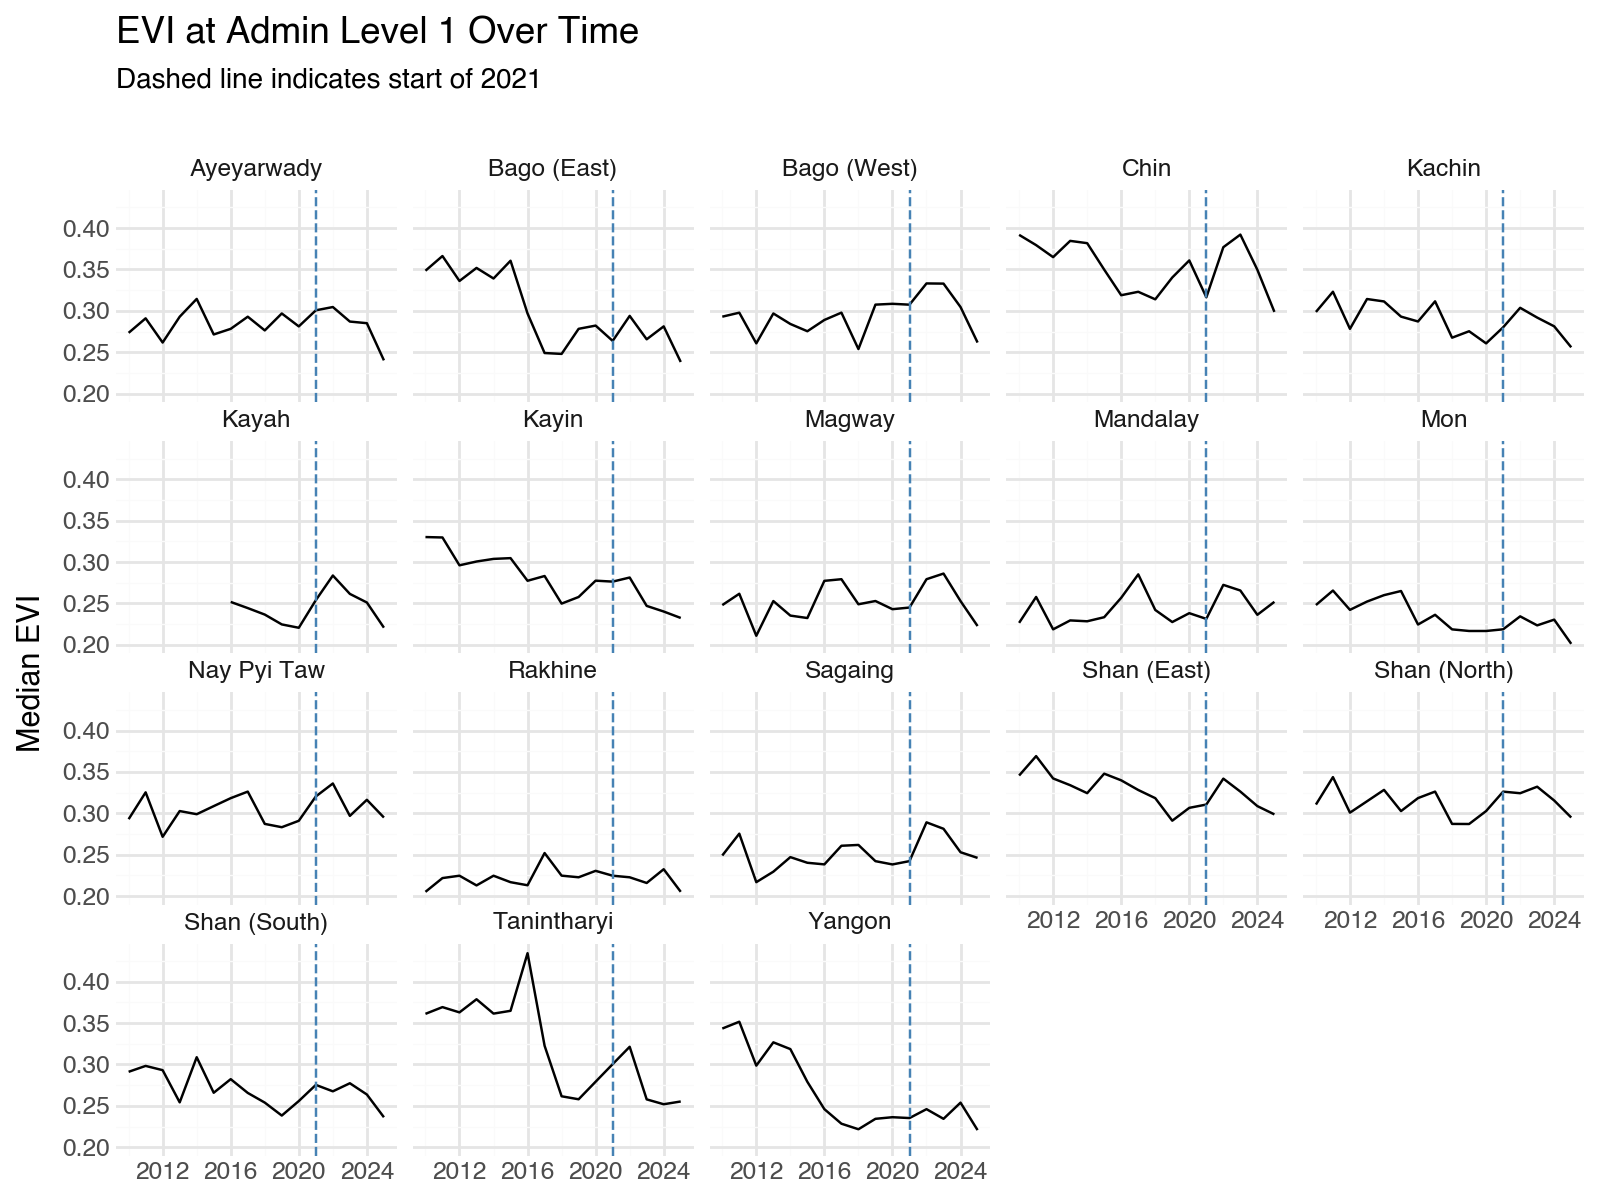

In [17]:
(
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="YS")])
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_line()
    + p9.geom_vline(
        p9.aes(xintercept=pd.to_datetime("2021-01-01")),
        linetype="dashed",
        color="steelblue",
    )
    + p9.facet_wrap("adm1_name")
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="4 year")
    + p9.theme_minimal()
    + p9.labs(
        title="EVI at Admin Level 1 Over Time",
        subtitle="Dashed line indicates start of 2021",
        x="",
        y="Median EVI",
    )
    + p9.theme(
        figure_size=(8, 6),
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

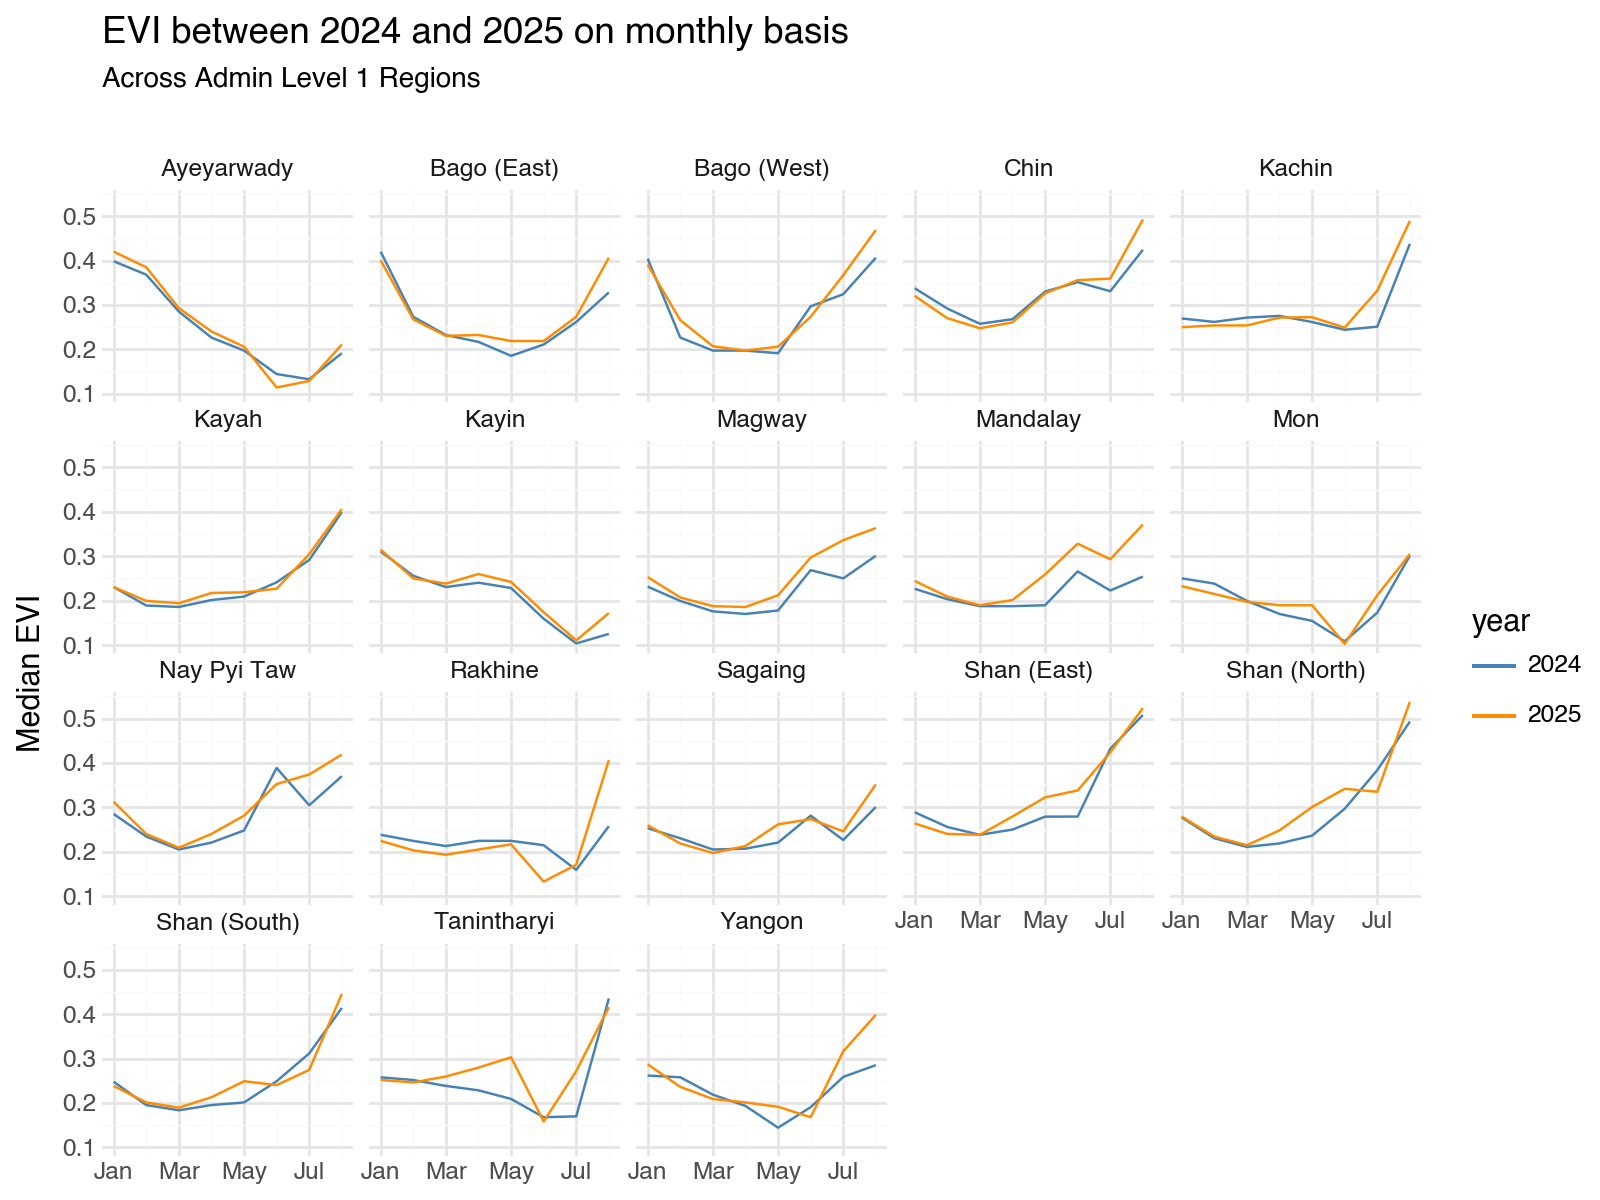

In [18]:
(
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="MS")])
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .assign(
        year=lambda df: df["date"].dt.year.astype(str),
        month=lambda df: df["date"].dt.month,
    )
    .query("date >= '2024-01-01' and month <= 8")
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="month", y="evi", color="year")
    + p9.geom_line()
    + p9.scale_x_continuous(
        breaks=list(range(1, 9, 2)),
        labels=[
            "Jan",
            "Mar",
            "May",
            "Jul",
        ],
    )
    + p9.scale_color_manual(values=["steelblue", "darkorange"])
    + p9.facet_wrap("adm1_name")
    + p9.theme_minimal()
    + p9.labs(
        title="EVI between 2024 and 2025 on monthly basis",
        subtitle="Across Admin Level 1 Regions",
        x="",
        y="Median EVI",
    )
    + p9.theme(
        figure_size=(8, 6),
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

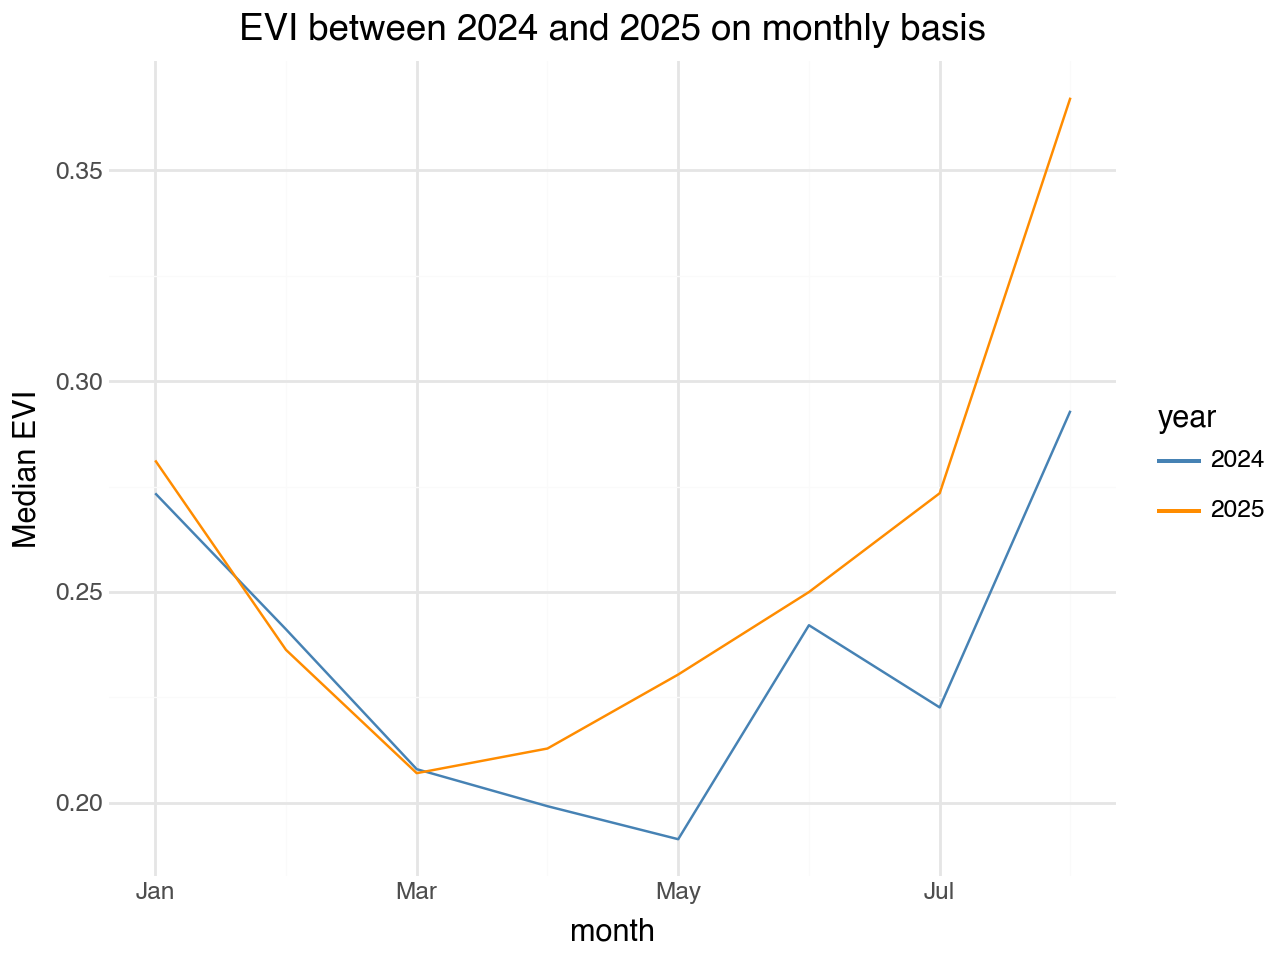

In [19]:
(
    evi_adm0_raw.groupby(pd.Grouper(freq="MS"))
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .assign(
        year=lambda df: df["date"].dt.year.astype(str),
        month=lambda df: df["date"].dt.month,
    )
    .query("date >= '2024-01-01' and month <= 8")
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="month", y="evi", color="year")
    + p9.geom_line()
    + p9.scale_x_continuous(
        breaks=list(range(1, 9, 2)),
        labels=[
            "Jan",
            "Mar",
            "May",
            "Jul",
        ],
    )
    + p9.scale_color_manual(values=["steelblue", "darkorange"])
    + p9.theme_minimal()
    + p9.labs(
        title="EVI between 2024 and 2025 on monthly basis",
        y="Median EVI",
    )
)

## GDP and EVI

For Agriculture GDP does not take into account livestock, fisheries, and forestry.

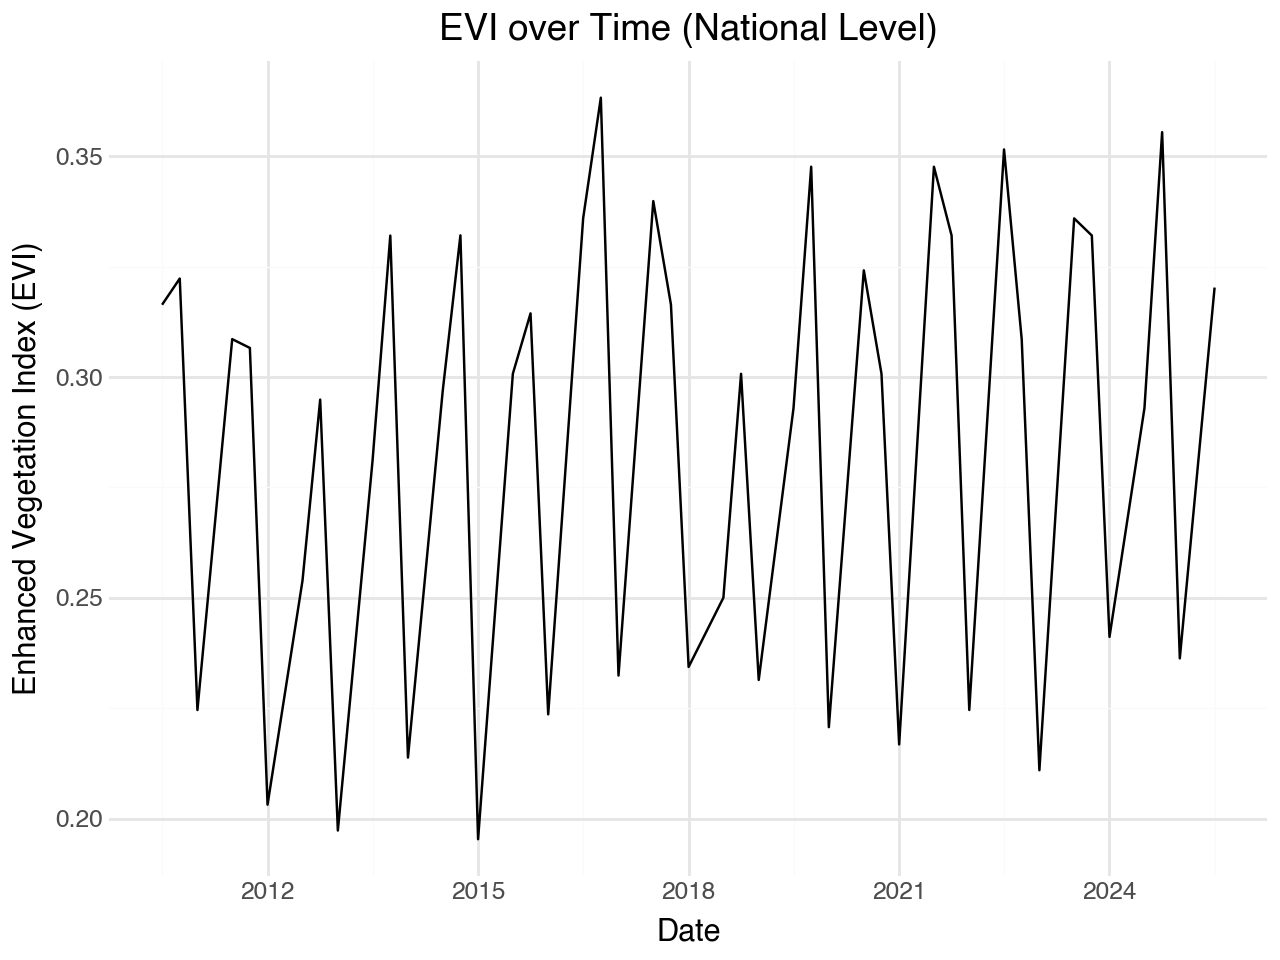

In [20]:
(
    evi_adm0.reset_index()
    .pipe(filter_growing_season)
    .query("year >= '2010-01-01'")
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_line()
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.labs(
        title="EVI over Time (National Level)",
        x="Date",
        y="Enhanced Vegetation Index (EVI)",
    )
    + p9.theme_minimal()
)

### Admin Level 0

In [21]:
evi_indicators = (
    gdp_agri_quarterly.join(evi_adm0, how="left")
    .join(ntl_adm0, how="left")
    .reset_index()
    .assign(
        evi_lag_1=lambda df: df["evi"].shift(1),
        evi_lag_2=lambda df: df["evi"].shift(2),
        ntl_mean_lag_1=lambda df: df["ntl_mean"].shift(1),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
        evi_lag_1_std=lambda df: StandardScaler().fit_transform(df[["evi_lag_1"]]),
        evi_lag_2_std=lambda df: StandardScaler().fit_transform(df[["evi_lag_2"]]),
        is_crop_season=lambda df: df["date"].dt.month.isin([7, 8, 9, 10, 11, 12, 1, 2]),
    )
    .set_index("date")
)

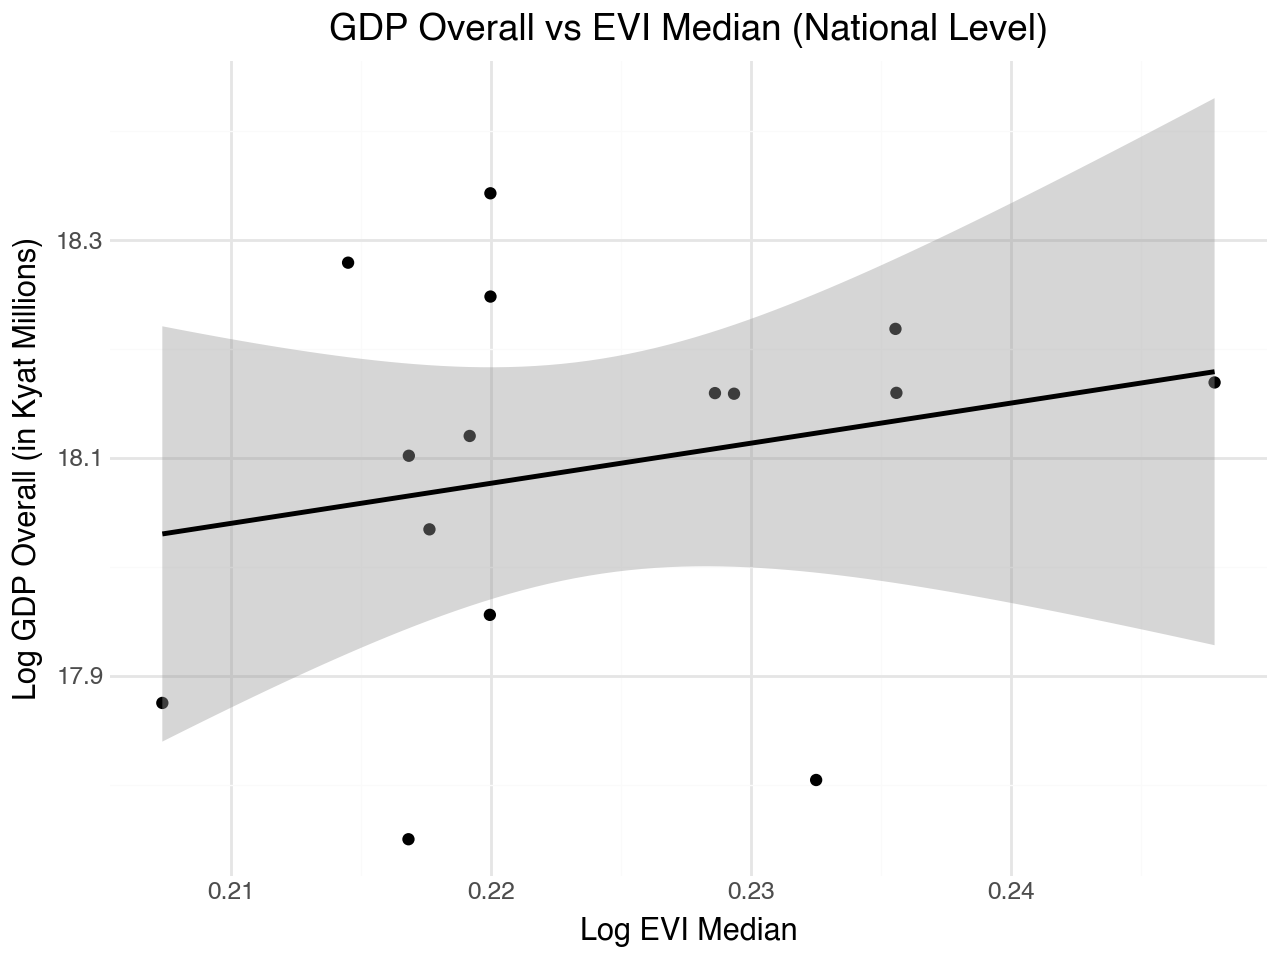

In [22]:
evi_adm0_annual = (
    evi_adm0_raw.groupby(pd.Grouper(freq="YS")).agg({"EVI": "median"}).pipe(clean_names)
)

(
    evi_adm0_annual.join(gdp_overall, how="inner")
    .reset_index()
    .assign(
        evi_log=lambda df: np.log1p(df["evi"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="evi_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs EVI Median (National Level)",
        x="Log EVI Median",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

In [23]:
model_gdp_evi_overall_log = smf.ols(
    "np.log1p(gdp_overall) ~ np.log1p(evi)",
    data=evi_adm0_annual.join(gdp_overall, how="inner"),
).fit()

model_gdp_evi_overall_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log1p(gdp_overall)   R-squared:                       0.049
Model:                               OLS   Adj. R-squared:                 -0.024
Method:                    Least Squares   F-statistic:                    0.6670
Date:                   Wed, 29 Oct 2025   Prob (F-statistic):              0.429
Time:                           17:27:47   Log-Likelihood:                 5.7683
No. Observations:                     15   AIC:                            -7.537
Df Residuals:                         13   BIC:                            -6.120
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.2666      1.011     17.071      0.000      15.081      19.452
np.log1p(evi)     3.6825      4.509      0.817      0.429      -6.058      13.423
==============================================================================
Omnibus:                        1.052   Durbin-Watson:                   0.228
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                0.683
Skew:                          -0.495   Prob(JB):                        0.711
Kurtosis:                       2.663   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

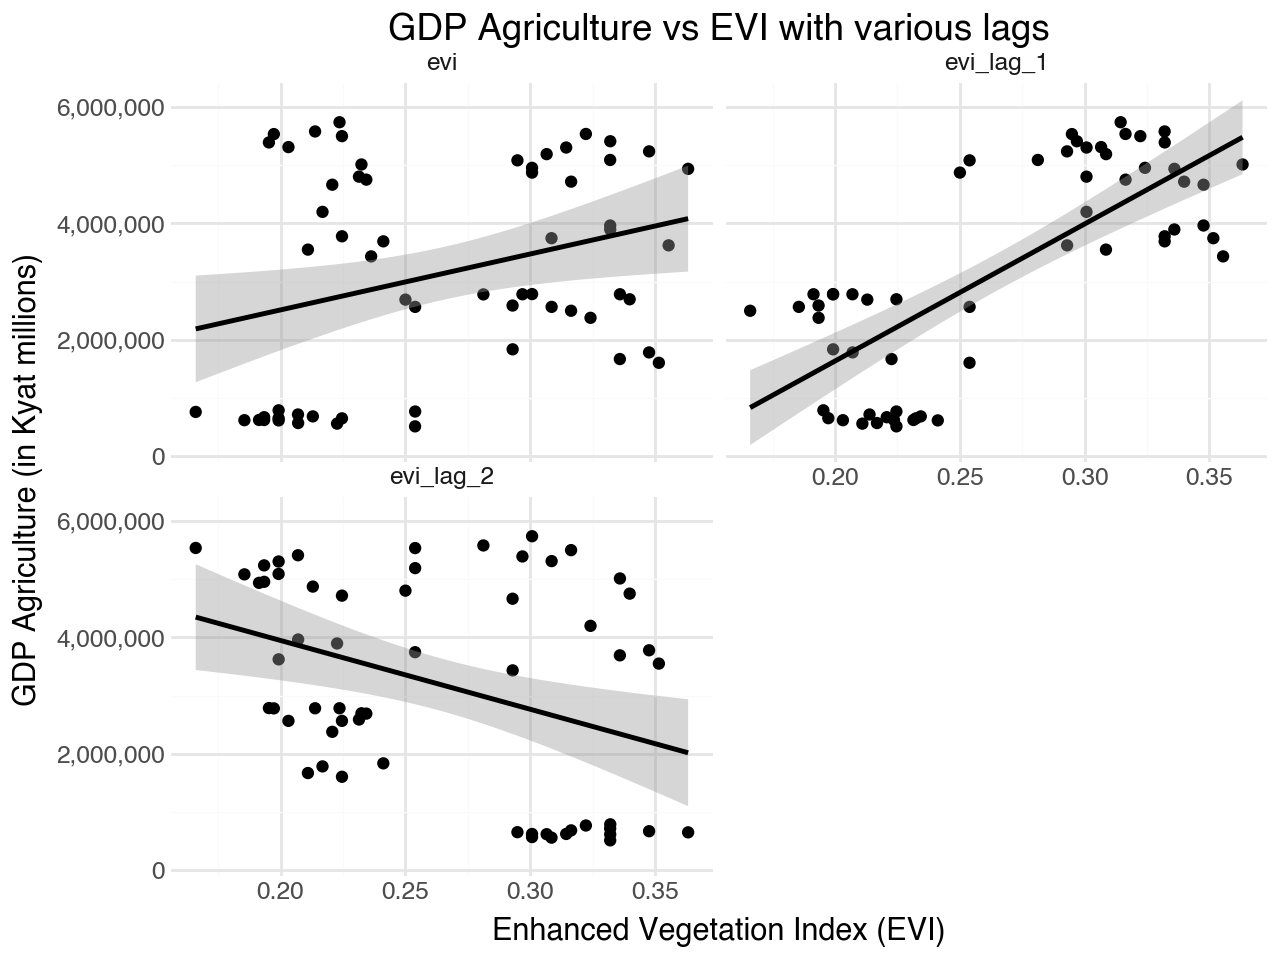

In [24]:
(
    evi_indicators.filter(["gdp_agri", "evi", "evi_lag_1", "evi_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_agri", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Agriculture vs EVI with various lags",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

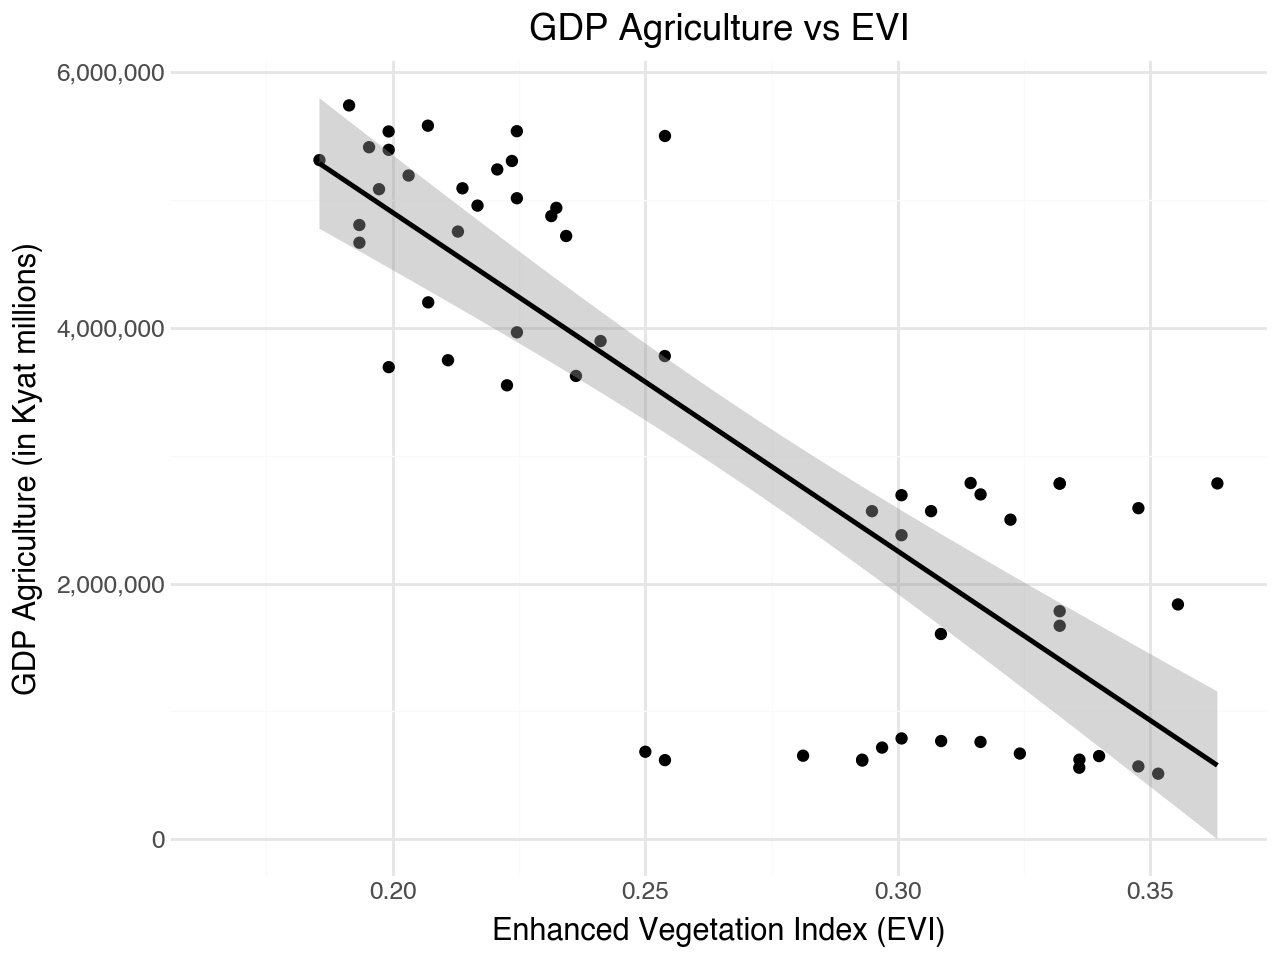

In [25]:
(
    evi_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri_lag_1")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

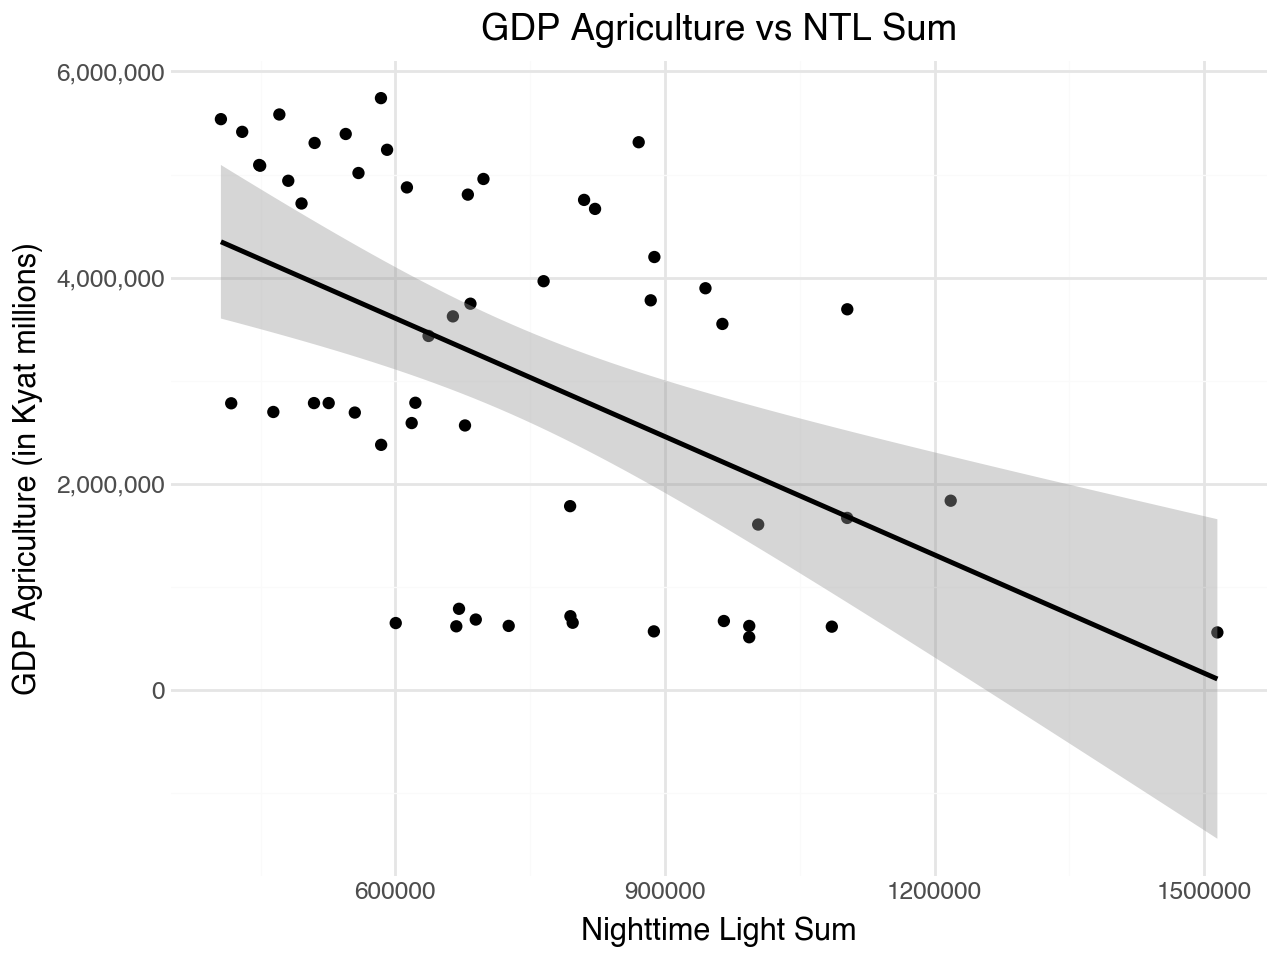

In [26]:
(
    evi_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Sum",
        x="Nighttime Light Sum",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

The following figure illustrates the correlation matrix between EVI, Nighttime Lights, and Overall GDP at national level.

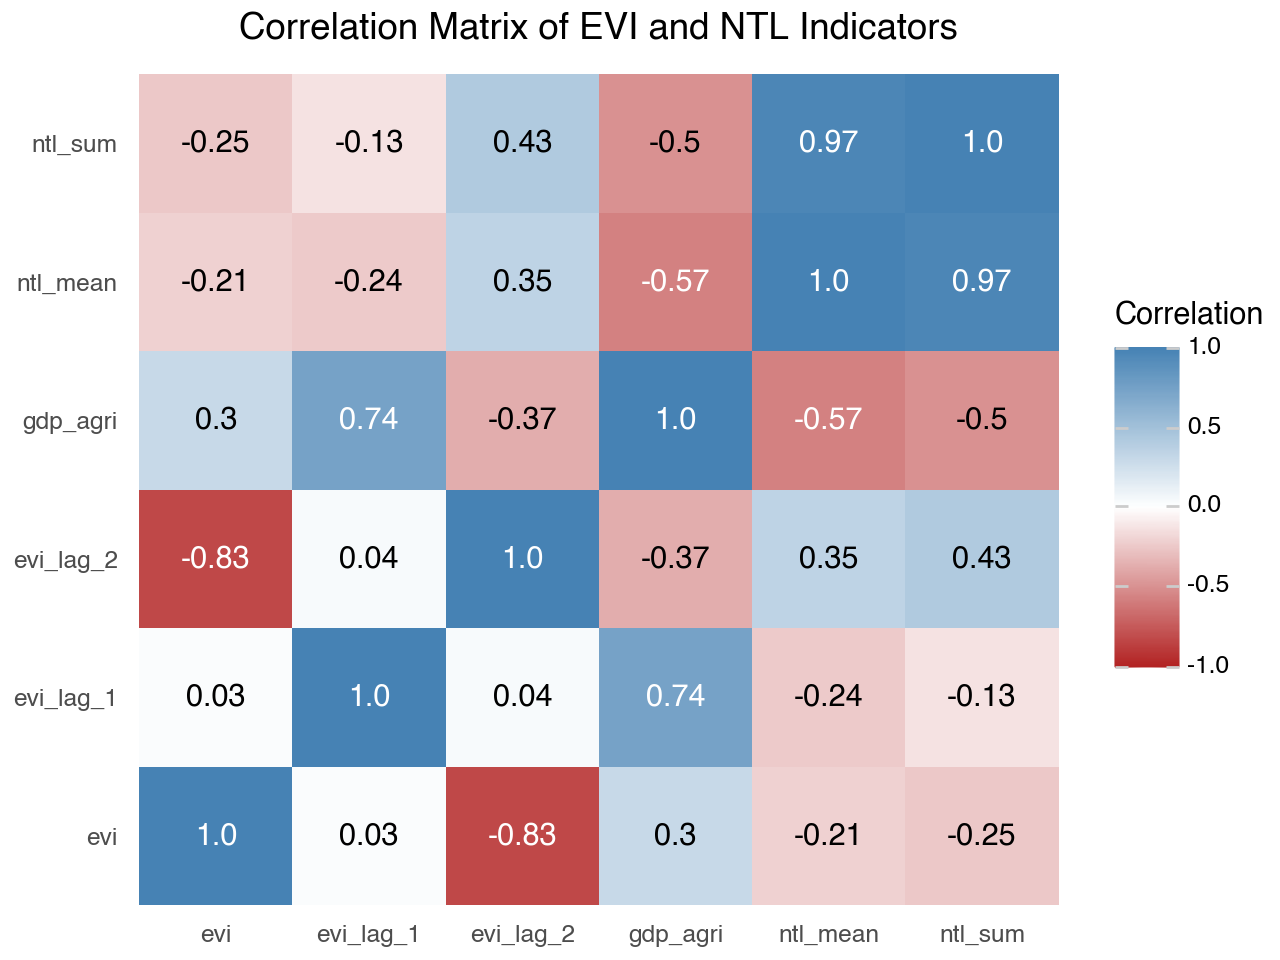

In [27]:
(
    evi_indicators.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "evi_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(
        title="Correlation Matrix of EVI and NTL Indicators",
        fill="Correlation",
        x="",
        y="",
    )
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [28]:
mod_1 = smf.ols("gdp_agri ~ evi", data=evi_indicators).fit()
mod_2 = smf.ols("gdp_agri ~ ntl_sum + evi", data=evi_indicators).fit()
mod_3 = smf.ols("gdp_agri ~ ntl_sum + evi + evi_lag_1", data=evi_indicators).fit()

Stargazer([mod_1, mod_2, mod_3])

In [29]:
mod_1 = smf.ols("np.log1p(gdp_agri) ~ np.log1p(evi)", data=evi_indicators).fit()
mod_2 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi)",
    data=evi_indicators,
).fit()
mod_3 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi) + np.log1p(evi_lag_1)",
    data=evi_indicators,
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [30]:
mod_1 = smf.ols("np.log1p(gdp_agri) ~ np.log1p(evi)", data=evi_indicators).fit()
mod_2 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi) + is_crop_season",
    data=evi_indicators,
).fit()
mod_3 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi) + np.log1p(evi_lag_1) + is_crop_season",
    data=evi_indicators,
).fit()

Stargazer([mod_1, mod_2, mod_3])

The figure below visualizes feature importance and effects across all samples in your dataset. Each dot represents one sample or observation, with color indicating the feature value (red for high values, blue for low values). The relationship between feature values and effects is revealed through color patterns: if red dots cluster on the right, high feature values lead to higher predictions, while if blue dots cluster on the right, low feature values increase predictions.

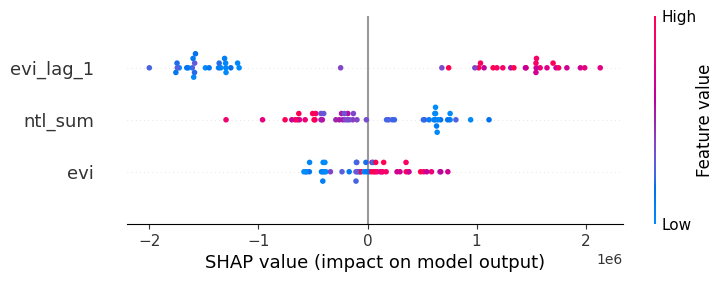

In [31]:
evi_indicators_clean = evi_indicators.dropna()
X = evi_indicators_clean[["evi", "ntl_sum", "evi_lag_1"]]
y = evi_indicators_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

### Admin Level 1

The Sectoral GDP at admin level 1 for all years was estimated based on the sectoral GDP proportions observed in 2015-2016. The proportions were assumed to remain constant over the years as shown below:

In [32]:
(
    gdp_adm1.filter(["adm1_name", "agriculture_pct"])
    .assign(
        agriculture_pct=lambda df: df["agriculture_pct"].apply(
            lambda x: "{:.1f}%".format(x * 100)
        )
    )
    .rename(columns={"agriculture_pct": "Agriculture"})
)

,adm1_name,Agriculture
0,Ayeyarwady,16.0%
1,Chin,0.5%
2,Kachin,2.1%
3,Kayah,0.5%
4,Kayin,2.4%
5,Magway,14.1%
6,Mandalay,8.3%
7,Mon,4.4%
8,Nay Pyi Taw,1.1%
9,Rakhine,3.3%


In [33]:
evi_indicators_adm1 = (
    gdp_agri_quarterly_adm1.join(evi_adm1, how="left")
    .join(ntl_adm1, how="left")
    .assign(
        gdp_agri_c=lambda df: df["gdp_agri"] - df["gdp_agri"].mean(),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
    )
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            evi_lag_1=df["evi"].shift(1),
            evi_lag_2=df["evi"].shift(2),
            evi_lag_1_std=lambda dff: StandardScaler().fit_transform(
                dff[["evi_lag_1"]]
            ),
            evi_lag_2_std=lambda dff: StandardScaler().fit_transform(
                dff[["evi_lag_2"]]
            ),
            ntl_sum_lag_1=df["ntl_sum"].shift(1),
            ntl_sum_lag_2=df["ntl_sum"].shift(2),
        ),
    )
    .set_index(["adm1_name", "date"])
)

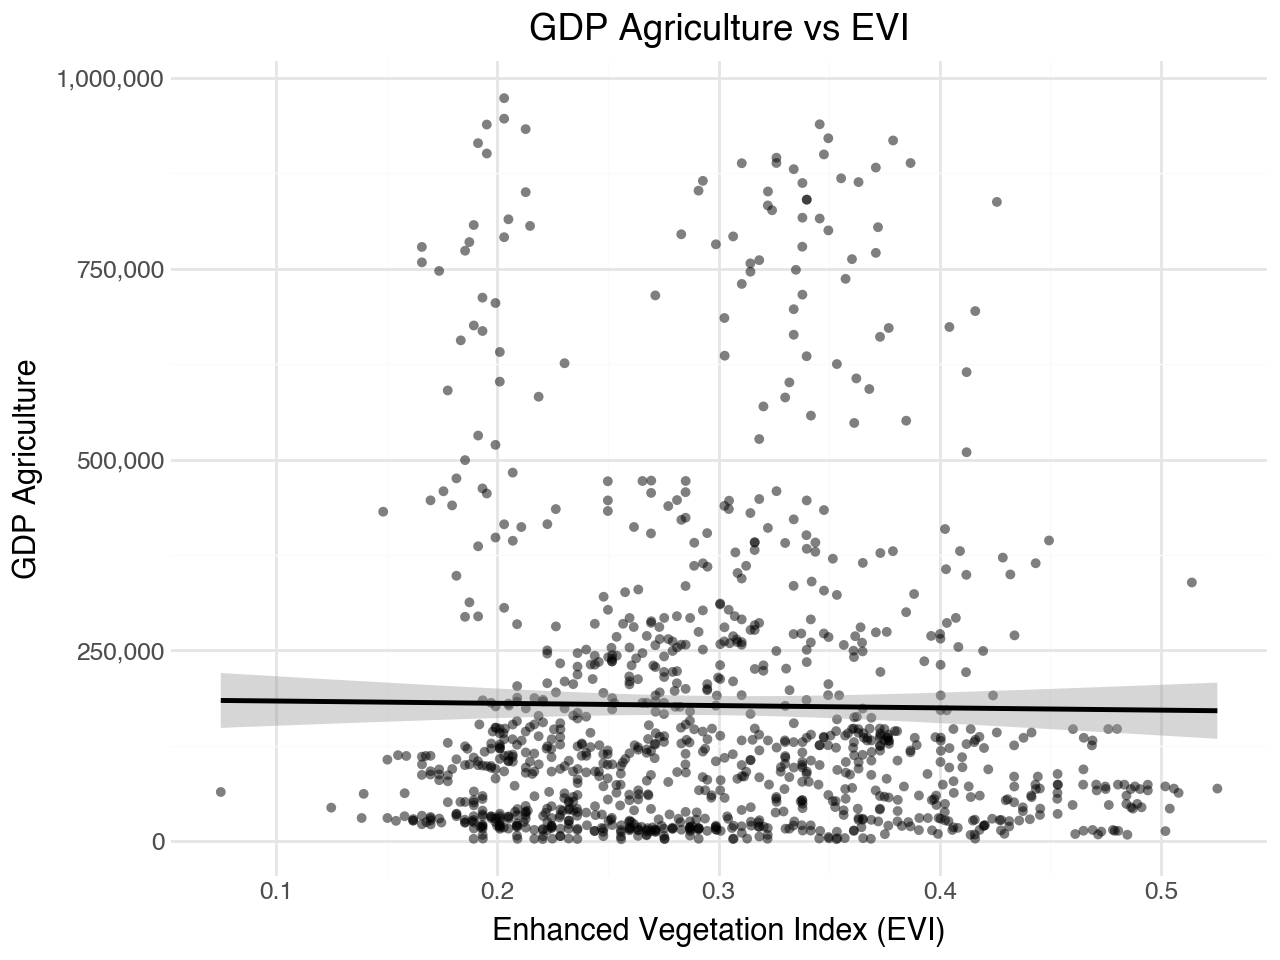

In [34]:
(
    evi_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

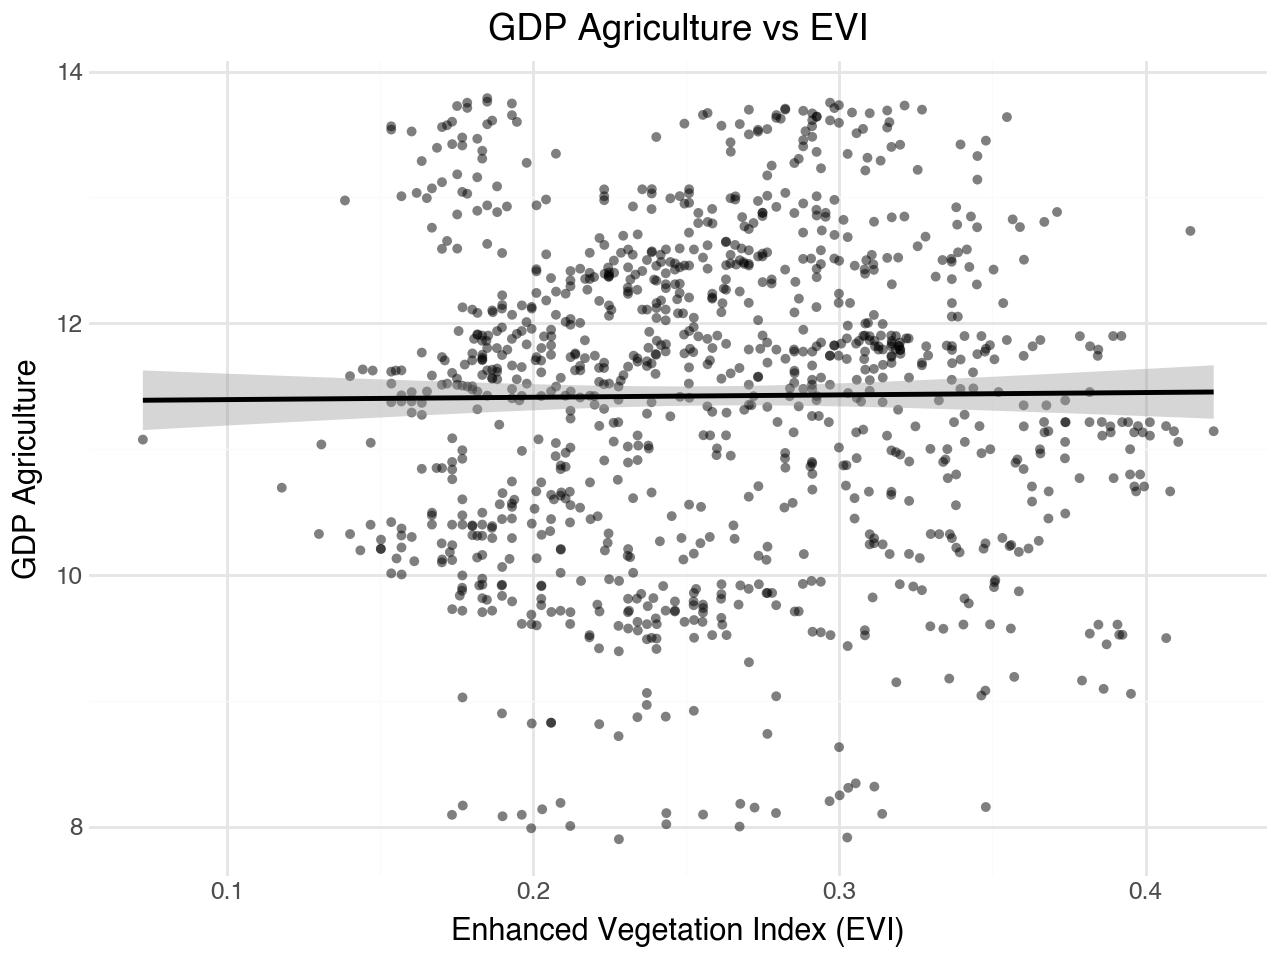

In [35]:
(
    evi_indicators_adm1.assign(
        evi_log=lambda df: np.log1p(df["evi"]),
        gdp_agri_log=lambda df: np.log1p(df["gdp_agri"]),
    ).pipe((p9.ggplot, "data"))
    + p9.aes(x="evi_log", y="gdp_agri_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

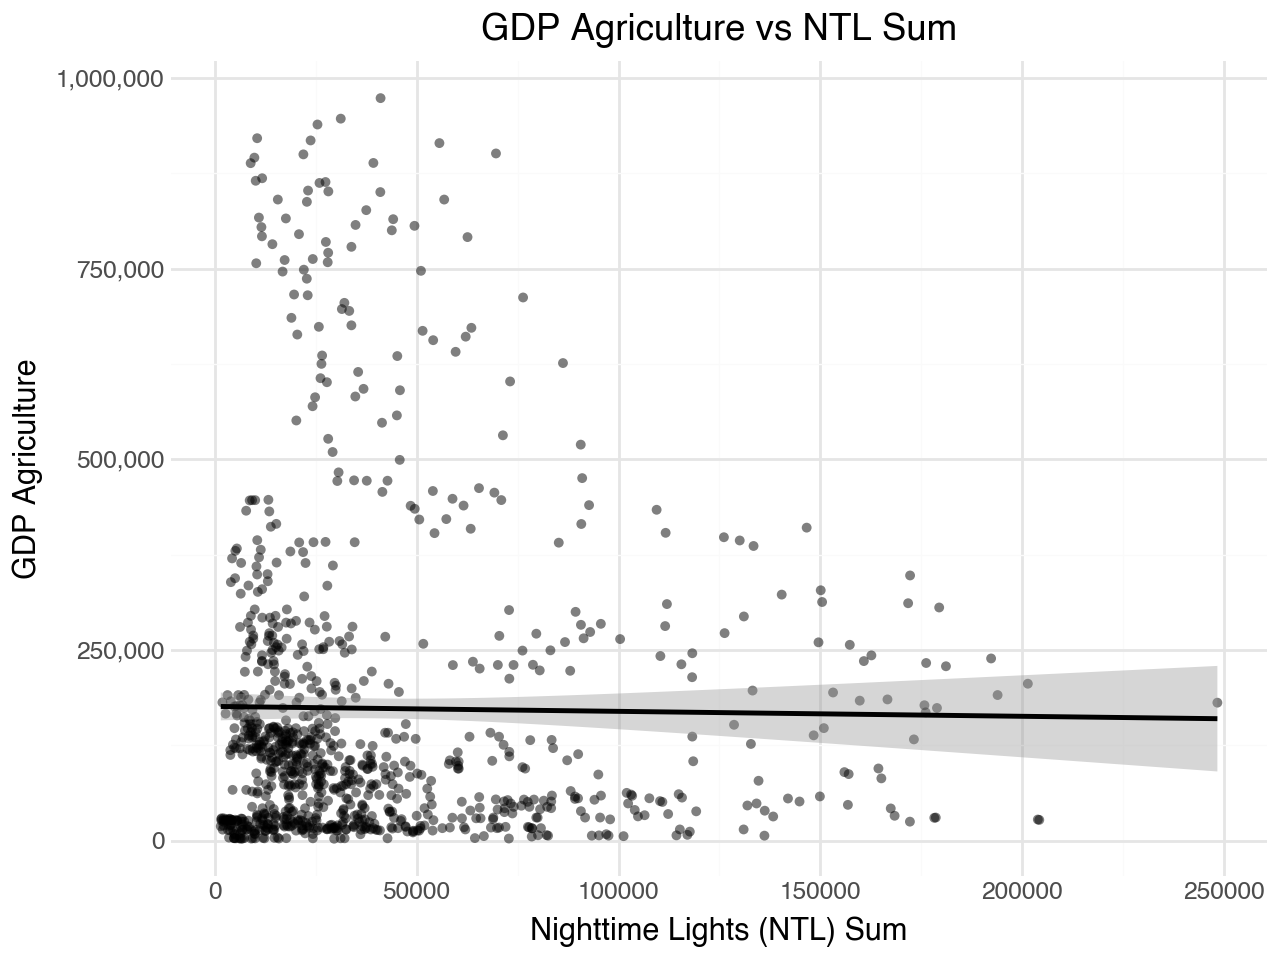

In [36]:
(
    evi_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Sum",
        x="Nighttime Lights (NTL) Sum",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

The following figures show the correlation matrix between EVI, Nighttime Lights, and Sectoral GDP (Manufacturing and Services) at admin level 1.

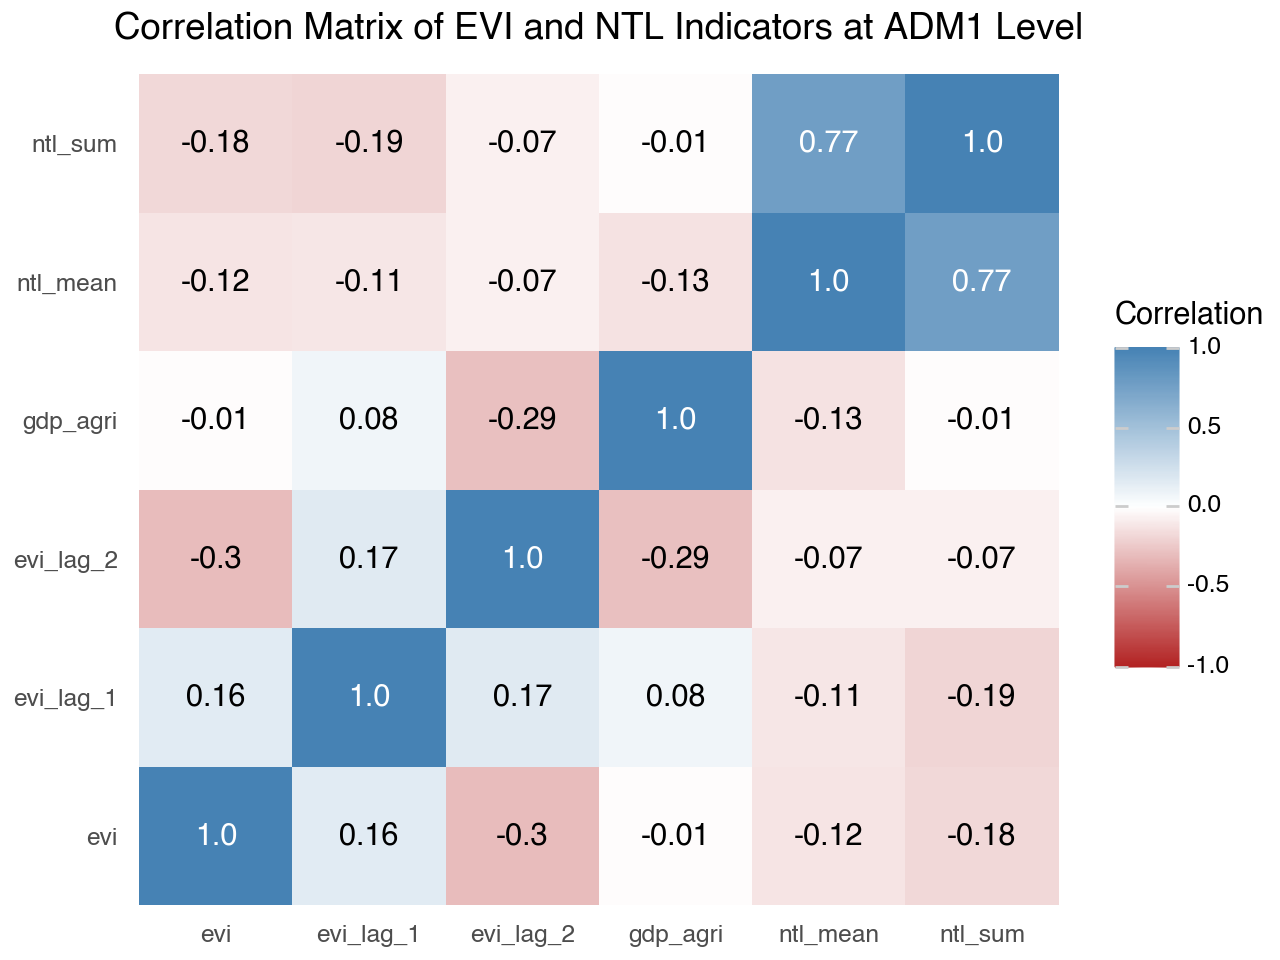

In [37]:
(
    evi_indicators_adm1.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "evi_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(
        title="Correlation Matrix of EVI and NTL Indicators at ADM1 Level",
        fill="Correlation",
        x="",
        y="",
    )
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [38]:
mod_1 = smf.ols("np.log1p(gdp_agri) ~ np.log1p(evi)", data=evi_indicators_adm1).fit()
mod_2 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi)", data=evi_indicators_adm1
).fit()
mod_3 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi) + np.log1p(evi_lag_1)",
    data=evi_indicators_adm1,
).fit()

Stargazer([mod_1, mod_2, mod_3])

The figure below visualizes feature importance and effects across all samples in your dataset. Each dot represents one sample or observation, with color indicating the feature value (red for high values, blue for low values). The relationship between feature values and effects is revealed through color patterns: if red dots cluster on the right, high feature values lead to higher predictions, while if blue dots cluster on the right, low feature values increase predictions.

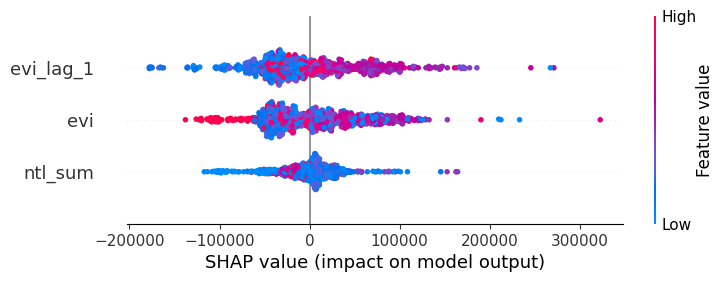

In [39]:
evi_indicators_adm_1_clean = evi_indicators_adm1.dropna()
X = evi_indicators_adm_1_clean[["evi", "ntl_sum", "evi_lag_1"]]
y = evi_indicators_adm_1_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)